# requirements

In [222]:
import warnings
warnings.filterwarnings("ignore")

In [223]:
import io
from pathlib import Path
from glob import glob
import os
import pandas as pd
import numpy as np
import nltk
import spacy
from functional import seq
import string
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import  confusion_matrix, roc_auc_score
from sklearn.metrics import mean_absolute_percentage_error,mean_squared_error,r2_score
from sklearn.metrics import r2_score,\
    mean_squared_error, mean_absolute_percentage_error, mean_absolute_error,\
    median_absolute_error


from lightgbm import LGBMClassifier, LGBMRegressor

from imblearn.over_sampling import RandomOverSampler

In [224]:
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier


In [225]:
from keras.preprocessing import text, sequence
from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Model
from keras.layers import LSTM, GRU, Bidirectional, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop,Adam, Adamax,Nadam
from keras.callbacks import EarlyStopping
import kerastuner
from kerastuner.tuners import RandomSearch,Hyperband, BayesianOptimization
from keras.callbacks import ModelCheckpoint,TensorBoard

from torch import nn
# from torch.utils import data
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch

In [226]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [227]:
import random

In [228]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [229]:
# !python -m spacy download uk_core_news_sm

In [230]:
stopwords = []
with open('./Ukrainian-Stopwords/stopwords_ua.txt') as f:
    for line in f.readlines():
        stopwords.append(line.strip())
STOPWORDS = set(stopwords)

In [231]:
# pip install pandarallel

In [232]:
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [233]:
pip install scikeras

UnboundLocalError: local variable 'child' referenced before assignment

In [ ]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 3.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 790.1 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 9.3 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 5.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from scikeras.wrappers import KerasClassifier

In [ ]:
plt.rcParams['figure.figsize']=(16,10)

In [ ]:
sns.set_style()

# EDA+processing

In [ ]:
data = pd.read_csv('./data/data.csv',delimiter='\t\t\t')

In [ ]:
data['smartphone_title'].nunique()

437

In [ ]:
nlp = spacy.load("uk_core_news_sm")

In [ ]:
doc = nlp(data['comment_text'].iloc[0].strip('\''))

In [ ]:
def preprocess(text):
    doc = nlp(text)
    tokens = seq(doc)\
        .map(lambda token: token.lemma_.lower())\
        .filter(lambda token: token not in STOPWORDS)\
        .filter(lambda token_list: len(token_list)>=1)\
        .filter(lambda token: token not in string.punctuation)\
        .to_list()
    return tokens

In [ ]:
data['comment_text_preprocessed'] = data['comment_text'].parallel_apply(preprocess)

In [ ]:
data["comment_text_preprocessed_string"] = data["comment_text_preprocessed"]\
        .parallel_apply(lambda tokens: " ".join(tokens))

The data is imbalanced, as it is showed on the plot below

<Axes: ylabel='Frequency'>

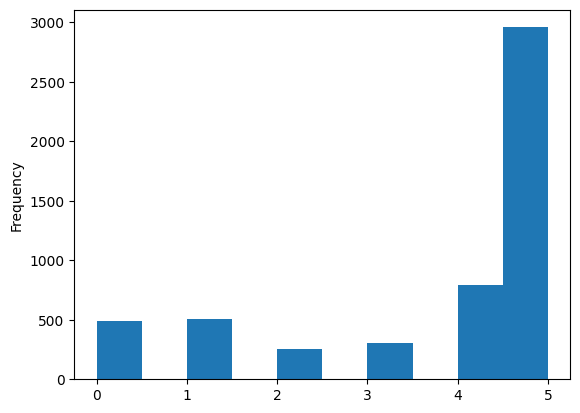

In [ ]:
data['score'].plot(kind='hist')

In [ ]:
data['comment_text_preprocessed_string']

0       гарний телефон круто виглядати розмір зручний ...
1       сегодня забрал телефон как оказалось телефон д...
2       добрий смартфон гарний обслуговування салон ро...
3        сучасний дорогий характеристика ціна нема рівний
4       целом телефон соответствует своей стоимости.\n...
                              ...                        
5303    тиждень користуватися дані смартфон функціонал...
5304    модель телефона новий очень классно работает м...
5305    замечательный телефон данную марка выбрал отзы...
5306                                попробую может зайдёт
5307                     дякувати швидко прийти працювати
Name: comment_text_preprocessed_string, Length: 5308, dtype: object

# Model 

## tf-idf vectors 

In [ ]:
tf_idf_vectorizer = TfidfVectorizer(strip_accents='ascii')

In [ ]:
X = data['comment_text_preprocessed_string']
y = data['score'].astype(float)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    random_state=42)

In [ ]:
tf_idf_vectorizer.fit(X_train)

TfidfVectorizer(strip_accents='ascii')

In [ ]:
X_train = tf_idf_vectorizer.transform(X_train)
X_test = tf_idf_vectorizer.transform(X_test)

In [ ]:
random_over_sampler = RandomOverSampler(random_state=42)
X_train, y_train = random_over_sampler.fit_resample(X_train,y_train)

## Classification pipeline: experiments

In [ ]:
def pipeline_for_classification_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train,y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test_proba = model.predict_proba(X_test)
    y_pred_test = model.predict(X_test)
    print('CLASSIFICATION REPORT: TRAIN')
    print(classification_report(y_train, y_pred_train))
    print('CLASSIFICATION REPORT: TEST')
    print(classification_report(y_test, y_pred_test))
    print('ROC-AUC: OVR')
    print(roc_auc_score(y_test, y_pred_test_proba, multi_class='ovr'))
    print('ROC-AUC: OVO')
    print(roc_auc_score(y_test, y_pred_test_proba, multi_class='ovo'))
    print('F1 weighted')
    print(f1_score(y_test,y_pred_test,average ='weighted'))
    sns.heatmap(confusion_matrix(y_train,np.round(y_pred_train)), annot=True, fmt = '.1f')
    return model

CLASSIFICATION REPORT: TRAIN
              precision    recall  f1-score   support

         0.0       0.80      0.23      0.36      2200
         1.0       0.70      0.27      0.39      2200
         2.0       0.73      0.33      0.46      2200
         3.0       0.73      0.30      0.42      2200
         4.0       0.71      0.25      0.37      2200
         5.0       0.20      0.84      0.33      2200

    accuracy                           0.37     13200
   macro avg       0.65      0.37      0.39     13200
weighted avg       0.65      0.37      0.39     13200

CLASSIFICATION REPORT: TEST
              precision    recall  f1-score   support

         0.0       0.13      0.06      0.08       119
         1.0       0.14      0.08      0.10       122
         2.0       0.08      0.07      0.08        69
         3.0       0.00      0.00      0.00        79
         4.0       0.21      0.11      0.14       179
         5.0       0.61      0.80      0.69       759

    accuracy        

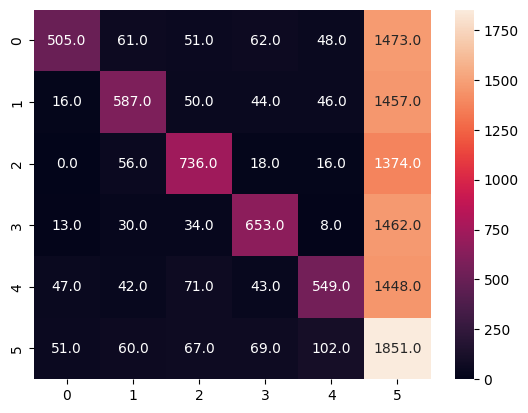

In [ ]:
log_reg= OneVsRestClassifier(LogisticRegression(solver='lbfgs',random_state=42))
log_reg = pipeline_for_classification_model(log_reg,X_train,X_test,y_train,y_test)

CLASSIFICATION REPORT: TRAIN
              precision    recall  f1-score   support

         0.0       0.80      0.23      0.36      2200
         1.0       0.70      0.27      0.39      2200
         2.0       0.73      0.33      0.46      2200
         3.0       0.73      0.30      0.42      2200
         4.0       0.71      0.25      0.37      2200
         5.0       0.20      0.84      0.33      2200

    accuracy                           0.37     13200
   macro avg       0.65      0.37      0.39     13200
weighted avg       0.65      0.37      0.39     13200

CLASSIFICATION REPORT: TEST
              precision    recall  f1-score   support

         0.0       0.13      0.06      0.08       119
         1.0       0.14      0.08      0.10       122
         2.0       0.08      0.07      0.08        69
         3.0       0.00      0.00      0.00        79
         4.0       0.21      0.11      0.14       179
         5.0       0.61      0.80      0.69       759

    accuracy        

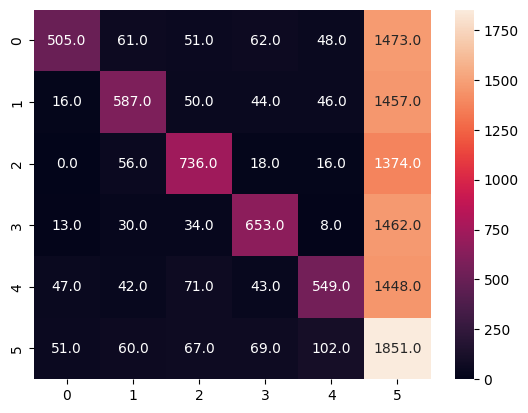

In [ ]:
log_reg= LogisticRegression(multi_class='ovr',random_state=42)
log_reg = pipeline_for_classification_model(log_reg,X_train,X_test,y_train,y_test)

CLASSIFICATION REPORT: TRAIN
              precision    recall  f1-score   support

         0.0       0.79      0.24      0.36      2200
         1.0       0.70      0.26      0.38      2200
         2.0       0.73      0.33      0.46      2200
         3.0       0.75      0.30      0.43      2200
         4.0       0.73      0.25      0.38      2200
         5.0       0.21      0.85      0.33      2200

    accuracy                           0.37     13200
   macro avg       0.65      0.37      0.39     13200
weighted avg       0.65      0.37      0.39     13200

CLASSIFICATION REPORT: TEST
              precision    recall  f1-score   support

         0.0       0.11      0.05      0.07       119
         1.0       0.15      0.09      0.11       122
         2.0       0.08      0.07      0.08        69
         3.0       0.00      0.00      0.00        79
         4.0       0.22      0.11      0.15       179
         5.0       0.61      0.80      0.69       759

    accuracy        

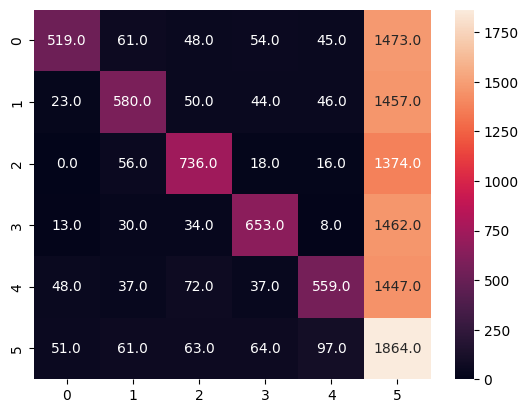

In [ ]:
log_reg= LogisticRegression(multi_class='multinomial',random_state=42)
log_reg = pipeline_for_classification_model(log_reg,X_train,X_test,y_train,y_test)

CLASSIFICATION REPORT: TRAIN
              precision    recall  f1-score   support

         0.0       0.20      0.88      0.33      2200
         1.0       0.67      0.24      0.35      2200
         2.0       0.66      0.31      0.42      2200
         3.0       0.67      0.28      0.39      2200
         4.0       0.74      0.21      0.33      2200
         5.0       0.65      0.12      0.20      2200

    accuracy                           0.34     13200
   macro avg       0.60      0.34      0.34     13200
weighted avg       0.60      0.34      0.34     13200

CLASSIFICATION REPORT: TEST
              precision    recall  f1-score   support

         0.0       0.08      0.66      0.14       119
         1.0       0.14      0.07      0.10       122
         2.0       0.09      0.09      0.09        69
         3.0       0.00      0.00      0.00        79
         4.0       0.24      0.09      0.13       179
         5.0       0.61      0.08      0.14       759

    accuracy        

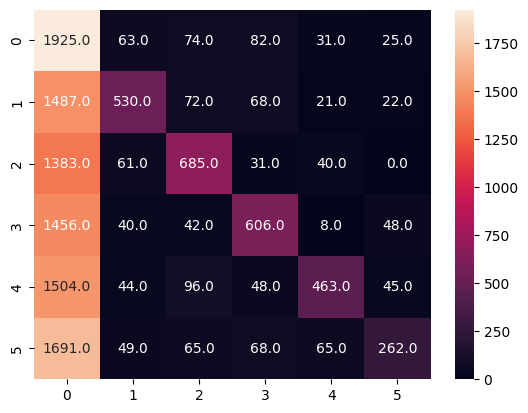

In [ ]:
mutlinomial_nb = MultinomialNB()
mutlinomial_nb = pipeline_for_classification_model(mutlinomial_nb, X_train, X_test, y_train, y_test)

CLASSIFICATION REPORT: TRAIN
              precision    recall  f1-score   support

         0.0       0.84      0.30      0.44      2200
         1.0       0.89      0.29      0.44      2200
         2.0       0.79      0.36      0.50      2200
         3.0       0.91      0.31      0.46      2200
         4.0       0.91      0.30      0.45      2200
         5.0       0.22      0.94      0.36      2200

    accuracy                           0.42     13200
   macro avg       0.76      0.42      0.44     13200
weighted avg       0.76      0.42      0.44     13200

CLASSIFICATION REPORT: TEST
              precision    recall  f1-score   support

         0.0       0.16      0.07      0.09       119
         1.0       0.18      0.07      0.10       122
         2.0       0.15      0.10      0.12        69
         3.0       0.00      0.00      0.00        79
         4.0       0.26      0.12      0.16       179
         5.0       0.60      0.86      0.71       759

    accuracy        

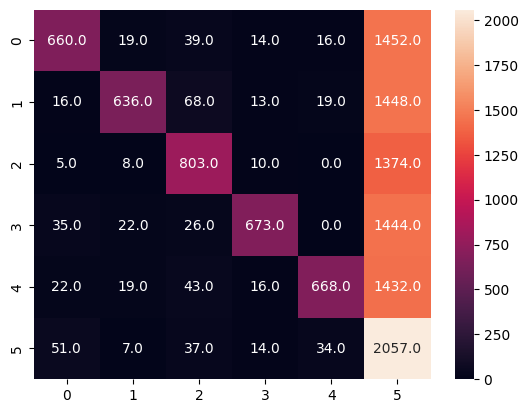

In [ ]:
random_forest = RandomForestClassifier(random_state=42)
random_forest = pipeline_for_classification_model(random_forest,X_train,X_test,y_train,y_test)

CLASSIFICATION REPORT: TRAIN
              precision    recall  f1-score   support

         0.0       0.78      0.22      0.35      2200
         1.0       0.85      0.24      0.37      2200
         2.0       0.76      0.33      0.46      2200
         3.0       0.86      0.28      0.42      2200
         4.0       0.84      0.23      0.37      2200
         5.0       0.21      0.91      0.34      2200

    accuracy                           0.37     13200
   macro avg       0.72      0.37      0.38     13200
weighted avg       0.72      0.37      0.38     13200

CLASSIFICATION REPORT: TEST
              precision    recall  f1-score   support

         0.0       0.08      0.03      0.05       119
         1.0       0.19      0.07      0.11       122
         2.0       0.13      0.10      0.11        69
         3.0       0.05      0.01      0.02        79
         4.0       0.21      0.09      0.13       179
         5.0       0.59      0.84      0.70       759

    accuracy        

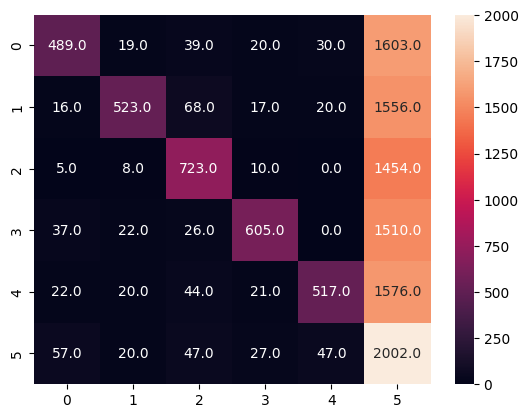

In [ ]:
lgbm = LGBMClassifier(random_state=42)
lgbm = pipeline_for_classification_model(lgbm,X_train,X_test,y_train,y_test)

## as a regression with clipping

In [ ]:
def pipeline_for_regression_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train,y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    y_pred_train = np.clip(y_pred_train,0,5)
    y_pred_test = np.clip(y_pred_test,0,5)
    print('REGRESSION REPORT: TRAIN')
    print('MSE')
    print(mean_squared_error(y_train, y_pred_train))
    print('MAE')
    print(mean_absolute_error(y_train, y_pred_train))
    print('MAPE')
    print(mean_absolute_percentage_error(y_train, y_pred_train))
    print('MedAE')
    print(median_absolute_error(y_train, y_pred_train))
    print('R2')
    print(r2_score(y_train, y_pred_train))
    print('F1 weighted')
    print(f1_score(y_train, np.round(y_pred_train), average = 'weighted'))
    
    
    print('REGRESSION REPORT: TEST')
    print('MSE')
    print(mean_squared_error(y_test, y_pred_test))
    print('MAE')
    print(mean_absolute_error(y_test, y_pred_test))
    print('MAPE')
    print(mean_absolute_percentage_error(y_test, y_pred_test))
    print('MedAE')
    print(median_absolute_error(y_test, y_pred_test))
    print('R2')
    print(r2_score(y_test, y_pred_test))
    print('F1 weighted')
    print(f1_score(y_test, np.round(y_pred_test), average = 'weighted'))
    
    return model

In [ ]:
lgbm = LGBMRegressor(random_state=42)
pipeline_for_regression_model(lgbm,X_train,X_test,y_train,y_test)

REGRESSION REPORT: TRAIN
MSE
2.4963177729712984
MAE
1.3147527626932347
MAPE
1644130056709892.0
MedAE
1.458550038464498
R2
0.14411962069555484
F1 weighted
0.20243693322517442
REGRESSION REPORT: TEST
MSE
4.514228256021407
MAE
1.9820026786893605
MAPE
1021367181452186.9
MedAE
2.458550038464498
R2
-0.4797721655165257
F1 weighted
0.03818897874949979


LGBMRegressor(random_state=42)

# RNN

In [ ]:
X = data['comment_text_preprocessed_string']
y = data['score'].astype(float)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=42)
onehot_encoder_target = OneHotEncoder(sparse_output=False).fit(np.sort(np.unique(y_train)).reshape(-1,1))
y_train_onehot = onehot_encoder_target.transform(np.array(y_train).reshape(-1,1))
y_test_onehot = onehot_encoder_target.transform(np.array(y_test).reshape(-1,1))

Vocabulary Size

In [ ]:
seq(data["comment_text_preprocessed"]).flatten().distinct().len()

22977

In [ ]:
NUM_CLASSES = 6
MAX_WORDS = 10000
MAX_SEQUENCE_LEN = 150
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(X_train)

In [ ]:
train_sequences = tokenizer.texts_to_sequences(X_train)
train_sequences_matrix = pad_sequences(train_sequences,maxlen=MAX_SEQUENCE_LEN)

test_sequences = tokenizer.texts_to_sequences(X_test)
test_sequences_matrix = pad_sequences(test_sequences,maxlen=MAX_SEQUENCE_LEN)

In [ ]:
train_sequences_matrix

array([[   0,    0,    0, ..., 2235,   32,  136],
       [   0,    0,    0, ...,  960, 7357, 4859],
       [   0,    0,    0, ..., 7358, 1328,  336],
       ...,
       [   0,    0,    0, ..., 1586,  331,  264],
       [   0,    0,    0, ...,  238,   37,    1],
       [   0,    0,    0, ...,  532, 1624,   25]], dtype=int32)

In [ ]:
train_sequences_matrix.shape

(3981, 150)

In [ ]:
def build_RNN(  
        lstm_units = 64,
        dense_size = 64,
        fc_size = 2,
        activation = 'relu',
        dropout_size = 0.5,
        embedding_size=128,
        optimizer='adam'): 
    inputs =Input(name='inputs',shape=[MAX_SEQUENCE_LEN])
    layer = Embedding(MAX_WORDS,embedding_size,input_length=MAX_SEQUENCE_LEN)(inputs)
    layer = Bidirectional(LSTM(lstm_units))(layer)
    for i in range(fc_size):
        layer = Dense(dense_size)(layer)
        layer = Activation(activation)(layer)
        layer = Dropout(dropout_size)(layer)
    layer = Dense(NUM_CLASSES,name='out_layer')(layer)
    layer = Activation('softmax')(layer)
    model = Model(inputs=inputs,outputs=layer)
    model.compile(loss='categorical_crossentropy',
                   optimizer=optimizer,
                   metrics=['accuracy'])
    return model

In [ ]:

param_grid = {
    'batch_size':[128],
    'lstm_units':[64,96],
    'fc_size':[1,2],
    # 'activation':['relu'],
    'dropout_size':[0.5],
    'embedding_size':[64,128],
    'optimizer':['rmsprop','adam'],
}
estimator = KerasClassifier(build_fn=build_RNN,
                        verbose=1,
                        activation='relu',
                        callbacks=[EarlyStopping(monitor='val_loss',
                                   min_delta=0.0001),
                                #    tf.keras.callbacks.TensorBoard(log_dir="logs")
                                ],
                        epochs=10,
                        batch_size=32,
                        lstm_units = 64,
                        dense_size = 64,
                        fc_size = 2,
                        dropout_size = 0.5,
                        embedding_size=128,
                        optimizer='adam')
grid = GridSearchCV(estimator=estimator, param_grid=param_grid)

In [ ]:
grid_result = grid.fit(train_sequences_matrix, y_train_onehot)

2023-04-27 01:05:49.109686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:05:49.111591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:05:49.114446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 01:05:49.890869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:05:49.893185: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:05:49.894958: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 12s 284ms/step - loss: 1.5587 - accuracy: 0.5308
Epoch 2/10
25/25 [==============================] - 8s 302ms/step - loss: 1.3843 - accuracy: 0.5490
Epoch 3/10
25/25 [==============================] - 7s 273ms/step - loss: 1.2791 - accuracy: 0.5572
Epoch 4/10
25/25 [==============================] - 7s 267ms/step - loss: 1.0748 - accuracy: 0.6131
Epoch 5/10
25/25 [==============================] - 7s 296ms/step - loss: 0.9502 - accuracy: 0.6523
Epoch 6/10
25/25 [==============================] - 7s 290ms/step - loss: 0.8457 - accuracy: 0.6869
Epoch 7/10
25/25 [==============================] - 7s 276ms/step - loss: 0.7742 - accuracy: 0.7180
Epoch 8/10
25/25 [==============================] - 7s 270ms/step - loss: 0.6984 - accuracy: 0.7522
Epoch 9/10
25/25 [==============================] - 7s 265ms/step - loss: 0.6164 - accuracy: 0.7751
Epoch 10/10
25/25 [==============================] - 7s 277ms/step - loss: 0.5653 - accuracy: 0.7770


2023-04-27 01:07:05.017638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:07:05.020457: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:07:05.022660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 2s 102ms/step


2023-04-27 01:07:06.755850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:07:06.758474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:07:06.760647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 01:07:07.721975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:07:07.724462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:07:07.726685: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 11s 245ms/step - loss: 1.5766 - accuracy: 0.5162
Epoch 2/10
25/25 [==============================] - 7s 273ms/step - loss: 1.3614 - accuracy: 0.5570
Epoch 3/10
25/25 [==============================] - 7s 276ms/step - loss: 1.2325 - accuracy: 0.5727
Epoch 4/10
25/25 [==============================] - 7s 283ms/step - loss: 1.0148 - accuracy: 0.6336
Epoch 5/10
25/25 [==============================] - 7s 272ms/step - loss: 0.8870 - accuracy: 0.6769
Epoch 6/10
25/25 [==============================] - 7s 284ms/step - loss: 0.7960 - accuracy: 0.7014
Epoch 7/10
25/25 [==============================] - 8s 340ms/step - loss: 0.7446 - accuracy: 0.7231
Epoch 8/10
25/25 [==============================] - 8s 312ms/step - loss: 0.6654 - accuracy: 0.7617
Epoch 9/10
25/25 [==============================] - 7s 286ms/step - loss: 0.6148 - accuracy: 0.7780
Epoch 10/10
25/25 [==============================] - 7s 266ms/step - loss: 0.5715 - accuracy: 0.7987


2023-04-27 01:08:34.475985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:08:34.477539: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:08:34.478721: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 1s 61ms/step


2023-04-27 01:08:35.603942: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:08:35.605566: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:08:35.606803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 01:08:35.805662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_1_grad/concat/split_1/split_dim' with dtype int32
	 [[{{node gradients/split_1_grad/concat/split_1/split_dim}}]]
2023-04-27 01:08:36.232089: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:08:36.234765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT:

25/25 [==============================] - 8s 167ms/step - loss: 1.5294 - accuracy: 0.5416
Epoch 2/10
25/25 [==============================] - 5s 196ms/step - loss: 1.3627 - accuracy: 0.5510
Epoch 3/10
25/25 [==============================] - 5s 213ms/step - loss: 1.2426 - accuracy: 0.5614
Epoch 4/10
25/25 [==============================] - 5s 218ms/step - loss: 1.0176 - accuracy: 0.6267
Epoch 5/10
25/25 [==============================] - 5s 213ms/step - loss: 0.8767 - accuracy: 0.6628
Epoch 6/10
25/25 [==============================] - 5s 219ms/step - loss: 0.8013 - accuracy: 0.6942
Epoch 7/10
25/25 [==============================] - 5s 215ms/step - loss: 0.7182 - accuracy: 0.7303
Epoch 8/10
25/25 [==============================] - 5s 212ms/step - loss: 0.6206 - accuracy: 0.7667
Epoch 9/10
25/25 [==============================] - 7s 290ms/step - loss: 0.5625 - accuracy: 0.7922
Epoch 10/10
25/25 [==============================] - 7s 270ms/step - loss: 0.5021 - accuracy: 0.8198


2023-04-27 01:09:36.197442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:09:36.202245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:09:36.205148: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 2s 80ms/step


2023-04-27 01:09:37.867481: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:09:37.870413: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:09:37.872257: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 01:09:38.902407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:09:38.905370: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:09:38.907420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 11s 242ms/step - loss: 1.5785 - accuracy: 0.5177
Epoch 2/10
25/25 [==============================] - 7s 290ms/step - loss: 1.3950 - accuracy: 0.5523
Epoch 3/10
25/25 [==============================] - 7s 296ms/step - loss: 1.3272 - accuracy: 0.5554
Epoch 4/10
25/25 [==============================] - 7s 292ms/step - loss: 1.1508 - accuracy: 0.5994
Epoch 5/10
25/25 [==============================] - 7s 287ms/step - loss: 0.9555 - accuracy: 0.6317
Epoch 6/10
25/25 [==============================] - 7s 280ms/step - loss: 0.8348 - accuracy: 0.6898
Epoch 7/10
25/25 [==============================] - 8s 339ms/step - loss: 0.7788 - accuracy: 0.7149
Epoch 8/10
25/25 [==============================] - 8s 304ms/step - loss: 0.6801 - accuracy: 0.7469
Epoch 9/10
25/25 [==============================] - 7s 270ms/step - loss: 0.5815 - accuracy: 0.7893
Epoch 10/10
25/25 [==============================] - 7s 279ms/step - loss: 0.5194 - accuracy: 0.8100


2023-04-27 01:10:56.468930: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:10:56.472174: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:10:56.474387: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 2s 91ms/step


2023-04-27 01:10:58.153570: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:10:58.155927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:10:58.158029: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 01:10:59.031201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:10:59.036748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:10:59.039038: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 10s 211ms/step - loss: 1.5157 - accuracy: 0.5303
Epoch 2/10
25/25 [==============================] - 6s 229ms/step - loss: 1.3556 - accuracy: 0.5495
Epoch 3/10
25/25 [==============================] - 5s 214ms/step - loss: 1.2418 - accuracy: 0.5529
Epoch 4/10
25/25 [==============================] - 5s 214ms/step - loss: 1.0559 - accuracy: 0.6132
Epoch 5/10
25/25 [==============================] - 5s 210ms/step - loss: 0.8916 - accuracy: 0.6615
Epoch 6/10
25/25 [==============================] - 5s 215ms/step - loss: 0.7923 - accuracy: 0.6973
Epoch 7/10
25/25 [==============================] - 6s 226ms/step - loss: 0.7185 - accuracy: 0.7290
Epoch 8/10
25/25 [==============================] - 5s 211ms/step - loss: 0.6459 - accuracy: 0.7639
Epoch 9/10
25/25 [==============================] - 5s 211ms/step - loss: 0.5949 - accuracy: 0.7915
Epoch 10/10
25/25 [==============================] - 5s 209ms/step - loss: 0.5352 - accuracy: 0.8069


2023-04-27 01:11:58.053818: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:11:58.055842: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:11:58.057563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 1s 66ms/step


2023-04-27 01:11:59.273012: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:11:59.274950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:11:59.276893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 01:11:59.508768: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:11:59.511869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:11:59.514448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 9s 205ms/step - loss: 1.5433 - accuracy: 0.5267
Epoch 2/10
25/25 [==============================] - 8s 322ms/step - loss: 1.3705 - accuracy: 0.5499
Epoch 3/10
25/25 [==============================] - 7s 284ms/step - loss: 1.2546 - accuracy: 0.5562
Epoch 4/10
25/25 [==============================] - 8s 326ms/step - loss: 1.0536 - accuracy: 0.6137
Epoch 5/10
25/25 [==============================] - 8s 316ms/step - loss: 0.9419 - accuracy: 0.6476
Epoch 6/10
25/25 [==============================] - 10s 372ms/step - loss: 0.8345 - accuracy: 0.6856
Epoch 7/10
25/25 [==============================] - 7s 267ms/step - loss: 0.7423 - accuracy: 0.7217
Epoch 8/10
25/25 [==============================] - 7s 263ms/step - loss: 0.6473 - accuracy: 0.7685
Epoch 9/10
25/25 [==============================] - 7s 264ms/step - loss: 0.5849 - accuracy: 0.7792
Epoch 10/10
25/25 [==============================] - 7s 281ms/step - loss: 0.5242 - accuracy: 0.8034


2023-04-27 01:13:16.197935: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:13:16.202778: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:13:16.206531: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 2s 88ms/step


2023-04-27 01:13:17.888076: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:13:17.891655: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:13:17.894332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 01:13:19.239240: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:13:19.241784: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:13:19.243647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 10s 201ms/step - loss: 1.5170 - accuracy: 0.5275
Epoch 2/10
25/25 [==============================] - 5s 205ms/step - loss: 1.3387 - accuracy: 0.5573
Epoch 3/10
25/25 [==============================] - 5s 215ms/step - loss: 1.2312 - accuracy: 0.5664
Epoch 4/10
25/25 [==============================] - 5s 212ms/step - loss: 1.0303 - accuracy: 0.6261
Epoch 5/10
25/25 [==============================] - 5s 209ms/step - loss: 0.8700 - accuracy: 0.6760
Epoch 6/10
25/25 [==============================] - 5s 213ms/step - loss: 0.7937 - accuracy: 0.7046
Epoch 7/10
25/25 [==============================] - 5s 211ms/step - loss: 0.7079 - accuracy: 0.7410
Epoch 8/10
25/25 [==============================] - 5s 220ms/step - loss: 0.6299 - accuracy: 0.7717
Epoch 9/10
25/25 [==============================] - 6s 221ms/step - loss: 0.5768 - accuracy: 0.7868
Epoch 10/10
25/25 [==============================] - 5s 211ms/step - loss: 0.5139 - accuracy: 0.8116


2023-04-27 01:14:18.219642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:14:18.221614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:14:18.223131: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 1s 68ms/step


2023-04-27 01:14:19.491327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:14:19.493479: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:14:19.495259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 01:14:19.714803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:14:19.717595: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:14:19.719720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 9s 203ms/step - loss: 1.5447 - accuracy: 0.5165
Epoch 2/10
25/25 [==============================] - 5s 209ms/step - loss: 1.3583 - accuracy: 0.5504
Epoch 3/10
25/25 [==============================] - 5s 215ms/step - loss: 1.1972 - accuracy: 0.5724
Epoch 4/10
25/25 [==============================] - 6s 256ms/step - loss: 0.9969 - accuracy: 0.6264
Epoch 5/10
25/25 [==============================] - 6s 224ms/step - loss: 0.8763 - accuracy: 0.6556
Epoch 6/10
25/25 [==============================] - 5s 210ms/step - loss: 0.7813 - accuracy: 0.7014
Epoch 7/10
25/25 [==============================] - 5s 215ms/step - loss: 0.7041 - accuracy: 0.7281
Epoch 8/10
25/25 [==============================] - 5s 214ms/step - loss: 0.6373 - accuracy: 0.7623
Epoch 9/10
25/25 [==============================] - 6s 229ms/step - loss: 0.5448 - accuracy: 0.8047
Epoch 10/10
25/25 [==============================] - 6s 223ms/step - loss: 0.5019 - accuracy: 0.8192


2023-04-27 01:15:18.729391: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:15:18.731628: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:15:18.734901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 1s 66ms/step


2023-04-27 01:15:19.987645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:15:19.989526: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:15:19.991086: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 01:15:20.213196: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:15:20.215446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:15:20.218595: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 12s 248ms/step - loss: 1.5492 - accuracy: 0.5300
Epoch 2/10
25/25 [==============================] - 7s 263ms/step - loss: 1.3757 - accuracy: 0.5548
Epoch 3/10
25/25 [==============================] - 9s 360ms/step - loss: 1.2539 - accuracy: 0.5642
Epoch 4/10
25/25 [==============================] - 10s 406ms/step - loss: 1.0370 - accuracy: 0.6126
Epoch 5/10
25/25 [==============================] - 10s 399ms/step - loss: 0.8994 - accuracy: 0.6597
Epoch 6/10
25/25 [==============================] - 9s 348ms/step - loss: 0.8226 - accuracy: 0.6879
Epoch 7/10
25/25 [==============================] - 7s 277ms/step - loss: 0.7463 - accuracy: 0.7187
Epoch 8/10
25/25 [==============================] - 7s 286ms/step - loss: 0.6852 - accuracy: 0.7435
Epoch 9/10
25/25 [==============================] - 7s 286ms/step - loss: 0.6218 - accuracy: 0.7683
Epoch 10/10
25/25 [==============================] - 8s 328ms/step - loss: 0.5655 - accuracy: 0.7884


2023-04-27 01:16:46.491640: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:16:46.493903: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:16:46.496239: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 1s 80ms/step


2023-04-27 01:16:47.856291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:16:47.858182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:16:47.859704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 01:16:48.091859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:16:48.094438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:16:48.096738: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 10s 219ms/step - loss: 1.5146 - accuracy: 0.5394
Epoch 2/10
25/25 [==============================] - 6s 237ms/step - loss: 1.3663 - accuracy: 0.5495
Epoch 3/10
25/25 [==============================] - 5s 205ms/step - loss: 1.2102 - accuracy: 0.5736
Epoch 4/10
25/25 [==============================] - 6s 233ms/step - loss: 0.9857 - accuracy: 0.6380
Epoch 5/10
25/25 [==============================] - 7s 300ms/step - loss: 0.8602 - accuracy: 0.6728
Epoch 6/10
25/25 [==============================] - 5s 202ms/step - loss: 0.7859 - accuracy: 0.7143
Epoch 7/10
25/25 [==============================] - 6s 260ms/step - loss: 0.7114 - accuracy: 0.7397
Epoch 8/10
25/25 [==============================] - 7s 269ms/step - loss: 0.6350 - accuracy: 0.7711
Epoch 9/10
25/25 [==============================] - 7s 265ms/step - loss: 0.5745 - accuracy: 0.7922
Epoch 10/10
25/25 [==============================] - 5s 217ms/step - loss: 0.5255 - accuracy: 0.8119


2023-04-27 01:17:53.053614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:17:53.055753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:17:53.057766: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 1s 63ms/step


2023-04-27 01:17:54.242146: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:17:54.243870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:17:54.245296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 01:17:54.471548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:17:54.474319: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:17:54.476183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 16s 498ms/step - loss: 1.5497 - accuracy: 0.5226
Epoch 2/10
25/25 [==============================] - 13s 513ms/step - loss: 1.3641 - accuracy: 0.5493
Epoch 3/10
25/25 [==============================] - 14s 563ms/step - loss: 1.2589 - accuracy: 0.5647
Epoch 4/10
25/25 [==============================] - 11s 454ms/step - loss: 1.0657 - accuracy: 0.6168
Epoch 5/10
25/25 [==============================] - 12s 472ms/step - loss: 0.9424 - accuracy: 0.6514
Epoch 6/10
25/25 [==============================] - 11s 425ms/step - loss: 0.8634 - accuracy: 0.6812
Epoch 7/10
25/25 [==============================] - 10s 406ms/step - loss: 0.7630 - accuracy: 0.7220
Epoch 8/10
25/25 [==============================] - 11s 442ms/step - loss: 0.6993 - accuracy: 0.7365
Epoch 9/10
25/25 [==============================] - 11s 434ms/step - loss: 0.6214 - accuracy: 0.7688
Epoch 10/10
25/25 [==============================] - 11s 428ms/step - loss: 0.5418 - accuracy: 0.8037


2023-04-27 01:20:20.229621: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:20:20.231610: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:20:20.236320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 2s 123ms/step


2023-04-27 01:20:22.090830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:20:22.092976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:20:22.094792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 01:20:22.996946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:20:22.999137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:20:23.004367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 15s 405ms/step - loss: 1.5335 - accuracy: 0.5294
Epoch 2/10
25/25 [==============================] - 11s 420ms/step - loss: 1.3563 - accuracy: 0.5570
Epoch 3/10
25/25 [==============================] - 12s 469ms/step - loss: 1.2058 - accuracy: 0.5981
Epoch 4/10
25/25 [==============================] - 12s 491ms/step - loss: 0.9916 - accuracy: 0.6433
Epoch 5/10
25/25 [==============================] - 13s 541ms/step - loss: 0.8657 - accuracy: 0.6763
Epoch 6/10
25/25 [==============================] - 10s 411ms/step - loss: 0.7871 - accuracy: 0.7077
Epoch 7/10
25/25 [==============================] - 11s 456ms/step - loss: 0.7109 - accuracy: 0.7504
Epoch 8/10
25/25 [==============================] - 10s 411ms/step - loss: 0.6415 - accuracy: 0.7736
Epoch 9/10
25/25 [==============================] - 11s 430ms/step - loss: 0.5884 - accuracy: 0.7909
Epoch 10/10
25/25 [==============================] - 20s 827ms/step - loss: 0.5207 - accuracy: 0.8100


2023-04-27 01:22:29.977731: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:22:29.981623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:22:29.987115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 4s 198ms/step


2023-04-27 01:22:33.351576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:22:33.354669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:22:33.357040: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 01:22:34.748829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:22:34.752755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:22:34.754633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 17s 437ms/step - loss: 1.5480 - accuracy: 0.5221
Epoch 2/10
25/25 [==============================] - 14s 554ms/step - loss: 1.3840 - accuracy: 0.5498
Epoch 3/10
25/25 [==============================] - 13s 502ms/step - loss: 1.2627 - accuracy: 0.5604
Epoch 4/10
25/25 [==============================] - 11s 436ms/step - loss: 1.0595 - accuracy: 0.6226
Epoch 5/10
25/25 [==============================] - 11s 450ms/step - loss: 0.9076 - accuracy: 0.6606
Epoch 6/10
25/25 [==============================] - 10s 418ms/step - loss: 0.7926 - accuracy: 0.7052
Epoch 7/10
25/25 [==============================] - 12s 464ms/step - loss: 0.6774 - accuracy: 0.7482
Epoch 8/10
25/25 [==============================] - 11s 437ms/step - loss: 0.6199 - accuracy: 0.7717
Epoch 9/10
25/25 [==============================] - 12s 461ms/step - loss: 0.5584 - accuracy: 0.7931
Epoch 10/10
25/25 [==============================] - 11s 424ms/step - loss: 0.4853 - accuracy: 0.8251


2023-04-27 01:24:35.687169: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:24:35.689400: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:24:35.691305: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 2s 137ms/step


2023-04-27 01:24:37.722403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:24:37.726303: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:24:37.729527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 01:24:38.807309: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:24:38.810743: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:24:38.813369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 16s 405ms/step - loss: 1.5200 - accuracy: 0.5388
Epoch 2/10
25/25 [==============================] - 11s 430ms/step - loss: 1.3498 - accuracy: 0.5554
Epoch 3/10
25/25 [==============================] - 10s 392ms/step - loss: 1.2016 - accuracy: 0.5711
Epoch 4/10
25/25 [==============================] - 10s 405ms/step - loss: 0.9804 - accuracy: 0.6336
Epoch 5/10
25/25 [==============================] - 10s 393ms/step - loss: 0.8537 - accuracy: 0.6634
Epoch 6/10
25/25 [==============================] - 10s 378ms/step - loss: 0.7807 - accuracy: 0.7020
Epoch 7/10
25/25 [==============================] - 10s 396ms/step - loss: 0.7057 - accuracy: 0.7385
Epoch 8/10
25/25 [==============================] - 10s 381ms/step - loss: 0.6626 - accuracy: 0.7504
Epoch 9/10
25/25 [==============================] - 10s 386ms/step - loss: 0.6160 - accuracy: 0.7749
Epoch 10/10
25/25 [==============================] - 10s 390ms/step - loss: 0.5213 - accuracy: 0.8104


2023-04-27 01:26:23.605890: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:26:23.607960: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:26:23.609851: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 2s 122ms/step


2023-04-27 01:26:25.415303: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:26:25.419074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:26:25.421799: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 01:26:25.703994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:26:25.706309: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:26:25.707962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 14s 384ms/step - loss: 1.5243 - accuracy: 0.5294
Epoch 2/10
25/25 [==============================] - 10s 391ms/step - loss: 1.3745 - accuracy: 0.5485
Epoch 3/10
25/25 [==============================] - 11s 429ms/step - loss: 1.2039 - accuracy: 0.5749
Epoch 4/10
25/25 [==============================] - 10s 383ms/step - loss: 1.0154 - accuracy: 0.6173
Epoch 5/10
25/25 [==============================] - 10s 396ms/step - loss: 0.8892 - accuracy: 0.6600
Epoch 6/10
25/25 [==============================] - 10s 388ms/step - loss: 0.8052 - accuracy: 0.6885
Epoch 7/10
25/25 [==============================] - 10s 391ms/step - loss: 0.7410 - accuracy: 0.7155
Epoch 8/10
25/25 [==============================] - 10s 399ms/step - loss: 0.6996 - accuracy: 0.7444
Epoch 9/10
25/25 [==============================] - 10s 382ms/step - loss: 0.6328 - accuracy: 0.7655
Epoch 10/10
25/25 [==============================] - 10s 392ms/step - loss: 0.5960 - accuracy: 0.7777


2023-04-27 01:28:09.731785: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:28:09.735379: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:28:09.738183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 2s 146ms/step


2023-04-27 01:28:11.716373: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:28:11.722270: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:28:11.725075: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 01:28:12.600159: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:28:12.604575: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:28:12.606468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 14s 375ms/step - loss: 1.5142 - accuracy: 0.5371
Epoch 2/10
25/25 [==============================] - 10s 383ms/step - loss: 1.3569 - accuracy: 0.5499
Epoch 3/10
25/25 [==============================] - 9s 377ms/step - loss: 1.2129 - accuracy: 0.5763
Epoch 4/10
25/25 [==============================] - 11s 447ms/step - loss: 1.0215 - accuracy: 0.6329
Epoch 5/10
25/25 [==============================] - 10s 395ms/step - loss: 0.9103 - accuracy: 0.6699
Epoch 6/10
25/25 [==============================] - 10s 387ms/step - loss: 0.8067 - accuracy: 0.7145
Epoch 7/10
25/25 [==============================] - 10s 401ms/step - loss: 0.7102 - accuracy: 0.7450
Epoch 8/10
25/25 [==============================] - 10s 390ms/step - loss: 0.6321 - accuracy: 0.7751
Epoch 9/10
25/25 [==============================] - 10s 392ms/step - loss: 0.5630 - accuracy: 0.8024
Epoch 10/10
25/25 [==============================] - 10s 400ms/step - loss: 0.5021 - accuracy: 0.8185


2023-04-27 01:29:56.427321: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:29:56.429928: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:29:56.431480: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 3s 136ms/step


2023-04-27 01:29:59.161842: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:29:59.163515: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:29:59.165006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 01:29:59.454427: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:29:59.457153: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:29:59.459153: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 15s 379ms/step - loss: 1.5539 - accuracy: 0.5281
Epoch 2/10
25/25 [==============================] - 10s 389ms/step - loss: 1.3863 - accuracy: 0.5551
Epoch 3/10
25/25 [==============================] - 9s 375ms/step - loss: 1.2150 - accuracy: 0.5777
Epoch 4/10
25/25 [==============================] - 9s 376ms/step - loss: 0.9888 - accuracy: 0.6414
Epoch 5/10
25/25 [==============================] - 10s 393ms/step - loss: 0.8664 - accuracy: 0.6703
Epoch 6/10
25/25 [==============================] - 10s 383ms/step - loss: 0.7784 - accuracy: 0.7058
Epoch 7/10
25/25 [==============================] - 11s 448ms/step - loss: 0.6902 - accuracy: 0.7529
Epoch 8/10
25/25 [==============================] - 11s 454ms/step - loss: 0.6107 - accuracy: 0.7765
Epoch 9/10
25/25 [==============================] - 11s 452ms/step - loss: 0.5444 - accuracy: 0.8022
Epoch 10/10
25/25 [==============================] - 10s 395ms/step - loss: 0.4851 - accuracy: 0.8257


2023-04-27 01:31:46.796149: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:31:46.798363: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:31:46.799786: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 2s 116ms/step


2023-04-27 01:31:48.521354: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:31:48.524372: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:31:48.526892: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 01:31:49.260615: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:31:49.264052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:31:49.265659: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 13s 338ms/step - loss: 1.5375 - accuracy: 0.5174
Epoch 2/10
25/25 [==============================] - 8s 302ms/step - loss: 1.3718 - accuracy: 0.5507
Epoch 3/10
25/25 [==============================] - 8s 301ms/step - loss: 1.2138 - accuracy: 0.5815
Epoch 4/10
25/25 [==============================] - 8s 308ms/step - loss: 1.0150 - accuracy: 0.6349
Epoch 5/10
25/25 [==============================] - 8s 303ms/step - loss: 0.8958 - accuracy: 0.6750
Epoch 6/10
25/25 [==============================] - 8s 308ms/step - loss: 0.7970 - accuracy: 0.7036
Epoch 7/10
25/25 [==============================] - 8s 308ms/step - loss: 0.7164 - accuracy: 0.7356
Epoch 8/10
25/25 [==============================] - 8s 310ms/step - loss: 0.6475 - accuracy: 0.7504
Epoch 9/10
25/25 [==============================] - 8s 320ms/step - loss: 0.5742 - accuracy: 0.7818
Epoch 10/10
25/25 [==============================] - 8s 333ms/step - loss: 0.5291 - accuracy: 0.8063


2023-04-27 01:33:12.136366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:33:12.138681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:33:12.142179: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 2s 214ms/step


2023-04-27 01:33:15.970055: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:33:15.978389: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:33:15.982424: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 01:33:17.241473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:33:17.243917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:33:17.246339: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 23s 612ms/step - loss: 1.5118 - accuracy: 0.5391
Epoch 2/10
25/25 [==============================] - 12s 469ms/step - loss: 1.3509 - accuracy: 0.5551
Epoch 3/10
25/25 [==============================] - 9s 353ms/step - loss: 1.2281 - accuracy: 0.5664
Epoch 4/10
25/25 [==============================] - 10s 412ms/step - loss: 1.0109 - accuracy: 0.6298
Epoch 5/10
25/25 [==============================] - 14s 556ms/step - loss: 0.8887 - accuracy: 0.6622
Epoch 6/10
25/25 [==============================] - 11s 457ms/step - loss: 0.8043 - accuracy: 0.7002
Epoch 7/10
25/25 [==============================] - 11s 428ms/step - loss: 0.7435 - accuracy: 0.7224
Epoch 8/10
25/25 [==============================] - 10s 416ms/step - loss: 0.6691 - accuracy: 0.7535
Epoch 9/10
25/25 [==============================] - 10s 400ms/step - loss: 0.6067 - accuracy: 0.7705
Epoch 10/10
25/25 [==============================] - 10s 409ms/step - loss: 0.5543 - accuracy: 0.7950


2023-04-27 01:35:17.962796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:35:17.965037: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:35:17.967210: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 2s 125ms/step


2023-04-27 01:35:19.937604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:35:19.940874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:35:19.942986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 01:35:20.870091: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:35:20.873799: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:35:20.875885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 17s 407ms/step - loss: 1.5130 - accuracy: 0.5300
Epoch 2/10
25/25 [==============================] - 10s 414ms/step - loss: 1.3475 - accuracy: 0.5501
Epoch 3/10
25/25 [==============================] - 11s 463ms/step - loss: 1.1387 - accuracy: 0.5997
Epoch 4/10
25/25 [==============================] - 10s 413ms/step - loss: 0.9395 - accuracy: 0.6408
Epoch 5/10
25/25 [==============================] - 10s 407ms/step - loss: 0.8312 - accuracy: 0.6857
Epoch 6/10
25/25 [==============================] - 11s 416ms/step - loss: 0.7563 - accuracy: 0.7130
Epoch 7/10
25/25 [==============================] - 10s 408ms/step - loss: 0.6947 - accuracy: 0.7403
Epoch 8/10
25/25 [==============================] - 10s 407ms/step - loss: 0.6250 - accuracy: 0.7724
Epoch 9/10
25/25 [==============================] - 11s 422ms/step - loss: 0.5527 - accuracy: 0.8028
Epoch 10/10
25/25 [==============================] - 8s 316ms/step - loss: 0.5026 - accuracy: 0.8122


2023-04-27 01:37:09.884501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:37:09.887699: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:37:09.890156: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 2s 117ms/step


2023-04-27 01:37:11.567462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:37:11.569050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:37:11.572586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 01:37:11.839273: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:37:11.842244: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:37:11.844727: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 11s 298ms/step - loss: 1.5931 - accuracy: 0.4943
Epoch 2/10
25/25 [==============================] - 7s 268ms/step - loss: 1.4327 - accuracy: 0.5455
Epoch 3/10
25/25 [==============================] - 7s 262ms/step - loss: 1.3298 - accuracy: 0.5499
Epoch 4/10
25/25 [==============================] - 7s 263ms/step - loss: 1.1411 - accuracy: 0.5751
Epoch 5/10
25/25 [==============================] - 8s 318ms/step - loss: 0.9986 - accuracy: 0.6307
Epoch 6/10
25/25 [==============================] - 6s 226ms/step - loss: 0.9186 - accuracy: 0.6473
Epoch 7/10
25/25 [==============================] - 5s 215ms/step - loss: 0.8825 - accuracy: 0.6595
Epoch 8/10
25/25 [==============================] - 6s 245ms/step - loss: 0.8318 - accuracy: 0.6822
Epoch 9/10
25/25 [==============================] - 7s 296ms/step - loss: 0.7753 - accuracy: 0.7041
Epoch 10/10
25/25 [==============================] - 6s 235ms/step - loss: 0.7001 - accuracy: 0.7387


2023-04-27 01:38:21.941205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:38:21.943338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:38:21.945086: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 1s 81ms/step


2023-04-27 01:38:23.402864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:38:23.406844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:38:23.408735: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 01:38:23.704802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:38:23.707367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:38:23.709160: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 12s 317ms/step - loss: 1.5512 - accuracy: 0.5212
Epoch 2/10
25/25 [==============================] - 7s 276ms/step - loss: 1.3765 - accuracy: 0.5545
Epoch 3/10
25/25 [==============================] - 7s 285ms/step - loss: 1.2374 - accuracy: 0.5570
Epoch 4/10
25/25 [==============================] - 7s 288ms/step - loss: 1.0589 - accuracy: 0.5790
Epoch 5/10
25/25 [==============================] - 7s 260ms/step - loss: 0.9410 - accuracy: 0.6352
Epoch 6/10
25/25 [==============================] - 7s 263ms/step - loss: 0.8720 - accuracy: 0.6527
Epoch 7/10
25/25 [==============================] - 7s 286ms/step - loss: 0.8068 - accuracy: 0.6747
Epoch 8/10
25/25 [==============================] - 7s 272ms/step - loss: 0.7481 - accuracy: 0.6948
Epoch 9/10
25/25 [==============================] - 7s 281ms/step - loss: 0.6997 - accuracy: 0.7275
Epoch 10/10
25/25 [==============================] - 7s 278ms/step - loss: 0.6386 - accuracy: 0.7608


2023-04-27 01:39:38.474391: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:39:38.476513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:39:38.478337: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 1s 75ms/step


2023-04-27 01:39:39.825860: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:39:39.827962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:39:39.829534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 01:39:40.080184: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:39:40.083603: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:39:40.086335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 12s 256ms/step - loss: 1.5820 - accuracy: 0.4619
Epoch 2/10
25/25 [==============================] - 7s 288ms/step - loss: 1.3912 - accuracy: 0.5488
Epoch 3/10
25/25 [==============================] - 6s 240ms/step - loss: 1.2446 - accuracy: 0.5535
Epoch 4/10
25/25 [==============================] - 6s 243ms/step - loss: 1.0494 - accuracy: 0.5984
Epoch 5/10
25/25 [==============================] - 6s 233ms/step - loss: 0.9347 - accuracy: 0.6364
Epoch 6/10
25/25 [==============================] - 6s 239ms/step - loss: 0.8732 - accuracy: 0.6553
Epoch 7/10
25/25 [==============================] - 6s 231ms/step - loss: 0.8126 - accuracy: 0.6810
Epoch 8/10
25/25 [==============================] - 6s 226ms/step - loss: 0.7646 - accuracy: 0.7052
Epoch 9/10
25/25 [==============================] - 6s 232ms/step - loss: 0.7202 - accuracy: 0.7137
Epoch 10/10
25/25 [==============================] - 6s 227ms/step - loss: 0.6785 - accuracy: 0.7451


2023-04-27 01:40:46.811194: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:40:46.813258: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:40:46.815021: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 1s 77ms/step


2023-04-27 01:40:48.156135: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:40:48.158256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:40:48.159710: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 01:40:48.408594: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:40:48.411456: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:40:48.414461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 10s 232ms/step - loss: 1.5558 - accuracy: 0.5312
Epoch 2/10
25/25 [==============================] - 6s 234ms/step - loss: 1.3925 - accuracy: 0.5542
Epoch 3/10
25/25 [==============================] - 6s 238ms/step - loss: 1.2476 - accuracy: 0.5551
Epoch 4/10
25/25 [==============================] - 6s 223ms/step - loss: 1.0560 - accuracy: 0.5808
Epoch 5/10
25/25 [==============================] - 6s 241ms/step - loss: 0.9307 - accuracy: 0.6345
Epoch 6/10
25/25 [==============================] - 6s 229ms/step - loss: 0.8650 - accuracy: 0.6641
Epoch 7/10
25/25 [==============================] - 6s 221ms/step - loss: 0.8314 - accuracy: 0.6835
Epoch 8/10
25/25 [==============================] - 6s 227ms/step - loss: 0.7723 - accuracy: 0.7014
Epoch 9/10
25/25 [==============================] - 6s 224ms/step - loss: 0.7035 - accuracy: 0.7306
Epoch 10/10
25/25 [==============================] - 6s 232ms/step - loss: 0.6459 - accuracy: 0.7601


2023-04-27 01:41:51.100918: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:41:51.102953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:41:51.104499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 1s 73ms/step


2023-04-27 01:41:52.524600: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:41:52.527384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:41:52.529295: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 01:41:53.292833: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:41:53.295001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:41:53.296656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 10s 238ms/step - loss: 1.6183 - accuracy: 0.4553
Epoch 2/10
25/25 [==============================] - 6s 236ms/step - loss: 1.4443 - accuracy: 0.5410
Epoch 3/10
25/25 [==============================] - 6s 231ms/step - loss: 1.3235 - accuracy: 0.5495
Epoch 4/10
25/25 [==============================] - 6s 224ms/step - loss: 1.1188 - accuracy: 0.5645
Epoch 5/10
25/25 [==============================] - 6s 241ms/step - loss: 0.9687 - accuracy: 0.6279
Epoch 6/10
25/25 [==============================] - 6s 235ms/step - loss: 0.8880 - accuracy: 0.6600
Epoch 7/10
25/25 [==============================] - 6s 228ms/step - loss: 0.8570 - accuracy: 0.6681
Epoch 8/10
25/25 [==============================] - 6s 228ms/step - loss: 0.8053 - accuracy: 0.6885
Epoch 9/10
25/25 [==============================] - 6s 232ms/step - loss: 0.7509 - accuracy: 0.7140
Epoch 10/10
25/25 [==============================] - 6s 239ms/step - loss: 0.6947 - accuracy: 0.7372


2023-04-27 01:42:56.010467: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:42:56.012269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:42:56.013966: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 1s 71ms/step


2023-04-27 01:42:57.292222: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:42:57.294611: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:42:57.296530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 01:42:57.562941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:42:57.565706: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:42:57.567733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 11s 227ms/step - loss: 1.5767 - accuracy: 0.4981
Epoch 2/10
25/25 [==============================] - 6s 227ms/step - loss: 1.4129 - accuracy: 0.5433
Epoch 3/10
25/25 [==============================] - 6s 226ms/step - loss: 1.2914 - accuracy: 0.5503
Epoch 4/10
25/25 [==============================] - 6s 224ms/step - loss: 1.0915 - accuracy: 0.5660
Epoch 5/10
25/25 [==============================] - 6s 221ms/step - loss: 0.9876 - accuracy: 0.6146
Epoch 6/10
25/25 [==============================] - 6s 227ms/step - loss: 0.9222 - accuracy: 0.6407
Epoch 7/10
25/25 [==============================] - 6s 225ms/step - loss: 0.8622 - accuracy: 0.6630
Epoch 8/10
25/25 [==============================] - 6s 224ms/step - loss: 0.8193 - accuracy: 0.6800
Epoch 9/10
25/25 [==============================] - 6s 236ms/step - loss: 0.7736 - accuracy: 0.6997
Epoch 10/10
25/25 [==============================] - 6s 239ms/step - loss: 0.7390 - accuracy: 0.7123


2023-04-27 01:44:00.204347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:44:00.208200: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:44:00.210072: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 1s 73ms/step


2023-04-27 01:44:01.599887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:44:01.601488: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:44:01.602767: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 01:44:01.859109: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:44:01.862339: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:44:01.864921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 10s 245ms/step - loss: 1.6005 - accuracy: 0.4776
Epoch 2/10
25/25 [==============================] - 6s 237ms/step - loss: 1.3985 - accuracy: 0.5551
Epoch 3/10
25/25 [==============================] - 6s 235ms/step - loss: 1.2727 - accuracy: 0.5601
Epoch 4/10
25/25 [==============================] - 6s 244ms/step - loss: 1.0647 - accuracy: 0.6144
Epoch 5/10
25/25 [==============================] - 6s 244ms/step - loss: 0.9189 - accuracy: 0.6537
Epoch 6/10
25/25 [==============================] - 6s 222ms/step - loss: 0.8529 - accuracy: 0.6653
Epoch 7/10
25/25 [==============================] - 5s 209ms/step - loss: 0.7955 - accuracy: 0.7011
Epoch 8/10
25/25 [==============================] - 5s 209ms/step - loss: 0.7349 - accuracy: 0.7231
Epoch 9/10
25/25 [==============================] - 6s 236ms/step - loss: 0.6819 - accuracy: 0.7463
Epoch 10/10
25/25 [==============================] - 5s 208ms/step - loss: 0.6002 - accuracy: 0.7642


2023-04-27 01:45:03.991530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:45:03.993570: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:45:03.995147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 1s 70ms/step


2023-04-27 01:45:05.265093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:45:05.266968: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:45:05.268459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 01:45:05.522327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:45:05.526203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:45:05.529003: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 9s 210ms/step - loss: 1.5970 - accuracy: 0.4939
Epoch 2/10
25/25 [==============================] - 5s 212ms/step - loss: 1.4061 - accuracy: 0.5516
Epoch 3/10
25/25 [==============================] - 5s 218ms/step - loss: 1.2735 - accuracy: 0.5504
Epoch 4/10
25/25 [==============================] - 5s 215ms/step - loss: 1.0679 - accuracy: 0.5859
Epoch 5/10
25/25 [==============================] - 5s 206ms/step - loss: 0.9555 - accuracy: 0.6298
Epoch 6/10
25/25 [==============================] - 5s 213ms/step - loss: 0.8721 - accuracy: 0.6553
Epoch 7/10
25/25 [==============================] - 5s 210ms/step - loss: 0.8169 - accuracy: 0.6763
Epoch 8/10
25/25 [==============================] - 5s 216ms/step - loss: 0.7783 - accuracy: 0.6911
Epoch 9/10
25/25 [==============================] - 6s 230ms/step - loss: 0.7309 - accuracy: 0.7187
Epoch 10/10
25/25 [==============================] - 5s 211ms/step - loss: 0.6730 - accuracy: 0.7435


2023-04-27 01:46:03.474628: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:46:03.476739: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:46:03.478382: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 1s 65ms/step


2023-04-27 01:46:04.718989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:46:04.720825: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:46:04.722237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 01:46:04.972128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:46:04.975249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:46:04.977590: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 9s 218ms/step - loss: 1.5581 - accuracy: 0.5221
Epoch 2/10
25/25 [==============================] - 5s 209ms/step - loss: 1.3905 - accuracy: 0.5542
Epoch 3/10
25/25 [==============================] - 5s 213ms/step - loss: 1.2751 - accuracy: 0.5557
Epoch 4/10
25/25 [==============================] - 6s 222ms/step - loss: 1.0750 - accuracy: 0.5903
Epoch 5/10
25/25 [==============================] - 5s 205ms/step - loss: 0.9411 - accuracy: 0.6374
Epoch 6/10
25/25 [==============================] - 5s 213ms/step - loss: 0.8801 - accuracy: 0.6600
Epoch 7/10
25/25 [==============================] - 5s 209ms/step - loss: 0.8064 - accuracy: 0.6801
Epoch 8/10
25/25 [==============================] - 5s 209ms/step - loss: 0.7484 - accuracy: 0.7030
Epoch 9/10
25/25 [==============================] - 6s 235ms/step - loss: 0.6879 - accuracy: 0.7451
Epoch 10/10
25/25 [==============================] - 5s 217ms/step - loss: 0.6286 - accuracy: 0.7554


2023-04-27 01:47:02.926961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:47:02.928832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:47:02.930272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 2s 63ms/step


2023-04-27 01:47:05.017966: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:47:05.021048: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:47:05.026497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 01:47:06.005066: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:47:06.011195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:47:06.014248: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 13s 220ms/step - loss: 1.5917 - accuracy: 0.5127
Epoch 2/10
25/25 [==============================] - 6s 248ms/step - loss: 1.4149 - accuracy: 0.5482
Epoch 3/10
25/25 [==============================] - 7s 270ms/step - loss: 1.2635 - accuracy: 0.5495
Epoch 4/10
25/25 [==============================] - 8s 306ms/step - loss: 1.0556 - accuracy: 0.5692
Epoch 5/10
25/25 [==============================] - 6s 219ms/step - loss: 0.9730 - accuracy: 0.6223
Epoch 6/10
25/25 [==============================] - 5s 217ms/step - loss: 0.8973 - accuracy: 0.6505
Epoch 7/10
25/25 [==============================] - 5s 216ms/step - loss: 0.8294 - accuracy: 0.6716
Epoch 8/10
25/25 [==============================] - 6s 226ms/step - loss: 0.7812 - accuracy: 0.6983
Epoch 9/10
25/25 [==============================] - 6s 232ms/step - loss: 0.7242 - accuracy: 0.7146
Epoch 10/10
25/25 [==============================] - 5s 215ms/step - loss: 0.6491 - accuracy: 0.7535


2023-04-27 01:48:12.595115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:48:12.597513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:48:12.599722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 1s 65ms/step


2023-04-27 01:48:13.803259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:48:13.804979: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:48:13.806905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 01:48:14.058733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:48:14.061232: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:48:14.063532: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 12s 319ms/step - loss: 1.5413 - accuracy: 0.5270
Epoch 2/10
25/25 [==============================] - 8s 320ms/step - loss: 1.3911 - accuracy: 0.5487
Epoch 3/10
25/25 [==============================] - 8s 311ms/step - loss: 1.2251 - accuracy: 0.5537
Epoch 4/10
25/25 [==============================] - 8s 311ms/step - loss: 1.0498 - accuracy: 0.6040
Epoch 5/10
25/25 [==============================] - 8s 327ms/step - loss: 0.9553 - accuracy: 0.6288
Epoch 6/10
25/25 [==============================] - 8s 310ms/step - loss: 0.8952 - accuracy: 0.6545
Epoch 7/10
25/25 [==============================] - 8s 327ms/step - loss: 0.8512 - accuracy: 0.6696
Epoch 8/10
25/25 [==============================] - 8s 307ms/step - loss: 0.8310 - accuracy: 0.6800
Epoch 9/10
25/25 [==============================] - 8s 320ms/step - loss: 0.7641 - accuracy: 0.7186
Epoch 10/10
25/25 [==============================] - 8s 312ms/step - loss: 0.7032 - accuracy: 0.7315


2023-04-27 01:49:37.833607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:49:37.835373: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:49:37.836992: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 2s 114ms/step


2023-04-27 01:49:39.411238: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:49:39.413365: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:49:39.414781: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 01:49:39.651927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:49:39.654307: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:49:39.656713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 12s 319ms/step - loss: 1.5542 - accuracy: 0.5118
Epoch 2/10
25/25 [==============================] - 8s 328ms/step - loss: 1.3835 - accuracy: 0.5538
Epoch 3/10
25/25 [==============================] - 8s 321ms/step - loss: 1.1981 - accuracy: 0.5661
Epoch 4/10
25/25 [==============================] - 8s 310ms/step - loss: 1.0014 - accuracy: 0.6239
Epoch 5/10
25/25 [==============================] - 8s 307ms/step - loss: 0.9038 - accuracy: 0.6521
Epoch 6/10
25/25 [==============================] - 8s 320ms/step - loss: 0.8331 - accuracy: 0.6816
Epoch 7/10
25/25 [==============================] - 8s 308ms/step - loss: 0.7771 - accuracy: 0.7093
Epoch 8/10
25/25 [==============================] - 8s 306ms/step - loss: 0.7176 - accuracy: 0.7303
Epoch 9/10
25/25 [==============================] - 8s 312ms/step - loss: 0.6814 - accuracy: 0.7532
Epoch 10/10
25/25 [==============================] - 8s 321ms/step - loss: 0.6223 - accuracy: 0.7655


2023-04-27 01:51:02.898321: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:51:02.900071: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:51:02.901576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 1s 95ms/step


2023-04-27 01:51:04.307187: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:51:04.310573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:51:04.312117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 01:51:04.555771: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:51:04.558793: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:51:04.561258: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 13s 321ms/step - loss: 1.6175 - accuracy: 0.4662
Epoch 2/10
25/25 [==============================] - 8s 307ms/step - loss: 1.4139 - accuracy: 0.5469
Epoch 3/10
25/25 [==============================] - 8s 327ms/step - loss: 1.2628 - accuracy: 0.5573
Epoch 4/10
25/25 [==============================] - 8s 305ms/step - loss: 1.0508 - accuracy: 0.6050
Epoch 5/10
25/25 [==============================] - 8s 304ms/step - loss: 0.9495 - accuracy: 0.6383
Epoch 6/10
25/25 [==============================] - 8s 317ms/step - loss: 0.8658 - accuracy: 0.6669
Epoch 7/10
25/25 [==============================] - 8s 322ms/step - loss: 0.8245 - accuracy: 0.6788
Epoch 8/10
25/25 [==============================] - 8s 304ms/step - loss: 0.7674 - accuracy: 0.7046
Epoch 9/10
25/25 [==============================] - 8s 311ms/step - loss: 0.7135 - accuracy: 0.7322
Epoch 10/10
25/25 [==============================] - 8s 314ms/step - loss: 0.6482 - accuracy: 0.7441


2023-04-27 01:52:28.596154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:52:28.598677: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:52:28.600664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 2s 113ms/step


2023-04-27 01:52:30.415117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:52:30.416908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:52:30.418411: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 01:52:30.649742: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:52:30.651605: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:52:30.653666: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 12s 329ms/step - loss: 1.5837 - accuracy: 0.4804
Epoch 2/10
25/25 [==============================] - 8s 310ms/step - loss: 1.4049 - accuracy: 0.5520
Epoch 3/10
25/25 [==============================] - 8s 311ms/step - loss: 1.2869 - accuracy: 0.5560
Epoch 4/10
25/25 [==============================] - 8s 324ms/step - loss: 1.0718 - accuracy: 0.5771
Epoch 5/10
25/25 [==============================] - 8s 324ms/step - loss: 0.9760 - accuracy: 0.6226
Epoch 6/10
25/25 [==============================] - 8s 308ms/step - loss: 0.8706 - accuracy: 0.6465
Epoch 7/10
25/25 [==============================] - 8s 320ms/step - loss: 0.8279 - accuracy: 0.6647
Epoch 8/10
25/25 [==============================] - 8s 312ms/step - loss: 0.7796 - accuracy: 0.6857
Epoch 9/10
25/25 [==============================] - 8s 307ms/step - loss: 0.7332 - accuracy: 0.7174
Epoch 10/10
25/25 [==============================] - 8s 314ms/step - loss: 0.6991 - accuracy: 0.7284


2023-04-27 01:53:53.935319: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:53:53.937272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:53:53.938703: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 2s 100ms/step


2023-04-27 01:53:55.458059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:53:55.460924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:53:55.462782: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 01:53:55.686100: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:53:55.688332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:53:55.690446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 12s 316ms/step - loss: 1.6099 - accuracy: 0.4662
Epoch 2/10
25/25 [==============================] - 8s 319ms/step - loss: 1.4163 - accuracy: 0.5441
Epoch 3/10
25/25 [==============================] - 8s 307ms/step - loss: 1.2707 - accuracy: 0.5545
Epoch 4/10
25/25 [==============================] - 8s 320ms/step - loss: 1.0458 - accuracy: 0.6160
Epoch 5/10
25/25 [==============================] - 8s 310ms/step - loss: 0.9374 - accuracy: 0.6358
Epoch 6/10
25/25 [==============================] - 8s 308ms/step - loss: 0.8810 - accuracy: 0.6537
Epoch 7/10
25/25 [==============================] - 8s 325ms/step - loss: 0.8361 - accuracy: 0.6776
Epoch 8/10
25/25 [==============================] - 9s 343ms/step - loss: 0.7547 - accuracy: 0.7049
Epoch 9/10
25/25 [==============================] - 8s 316ms/step - loss: 0.7062 - accuracy: 0.7359
Epoch 10/10
25/25 [==============================] - 8s 324ms/step - loss: 0.6286 - accuracy: 0.7680


2023-04-27 01:55:20.185722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:55:20.187661: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:55:20.189198: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 2s 105ms/step


2023-04-27 01:55:21.738392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:55:21.740019: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:55:21.741716: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 01:55:21.971358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:55:21.973823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:55:21.976089: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 13s 330ms/step - loss: 1.5776 - accuracy: 0.5179
Epoch 2/10
25/25 [==============================] - 8s 319ms/step - loss: 1.4275 - accuracy: 0.5471
Epoch 3/10
25/25 [==============================] - 8s 333ms/step - loss: 1.3004 - accuracy: 0.5531
Epoch 4/10
25/25 [==============================] - 8s 327ms/step - loss: 1.1037 - accuracy: 0.6002
Epoch 5/10
25/25 [==============================] - 8s 330ms/step - loss: 0.9814 - accuracy: 0.6247
Epoch 6/10
25/25 [==============================] - 8s 319ms/step - loss: 0.9121 - accuracy: 0.6429
Epoch 7/10
25/25 [==============================] - 8s 316ms/step - loss: 0.8547 - accuracy: 0.6608
Epoch 8/10
25/25 [==============================] - 9s 362ms/step - loss: 0.8010 - accuracy: 0.6746
Epoch 9/10
25/25 [==============================] - 8s 315ms/step - loss: 0.7596 - accuracy: 0.7120
Epoch 10/10
25/25 [==============================] - 9s 345ms/step - loss: 0.7120 - accuracy: 0.7236


2023-04-27 01:56:49.823056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:56:49.825559: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:56:49.828953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 2s 119ms/step


2023-04-27 01:56:51.542334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:56:51.545053: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:56:51.548202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 01:56:51.795793: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:56:51.798752: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:56:51.801025: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 12s 338ms/step - loss: 1.5683 - accuracy: 0.5086
Epoch 2/10
25/25 [==============================] - 8s 313ms/step - loss: 1.3938 - accuracy: 0.5491
Epoch 3/10
25/25 [==============================] - 8s 322ms/step - loss: 1.2444 - accuracy: 0.5573
Epoch 4/10
25/25 [==============================] - 8s 315ms/step - loss: 1.0559 - accuracy: 0.5918
Epoch 5/10
25/25 [==============================] - 8s 329ms/step - loss: 0.9344 - accuracy: 0.6267
Epoch 6/10
25/25 [==============================] - 8s 319ms/step - loss: 0.8610 - accuracy: 0.6587
Epoch 7/10
25/25 [==============================] - 8s 320ms/step - loss: 0.8072 - accuracy: 0.6772
Epoch 8/10
25/25 [==============================] - 8s 328ms/step - loss: 0.7419 - accuracy: 0.7184
Epoch 9/10
25/25 [==============================] - 9s 341ms/step - loss: 0.7057 - accuracy: 0.7347
Epoch 10/10
25/25 [==============================] - 8s 319ms/step - loss: 0.6535 - accuracy: 0.7451


2023-04-27 01:58:17.408227: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:58:17.410370: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:58:17.413103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 1s 102ms/step


2023-04-27 01:58:18.896878: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:58:18.899245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:58:18.900907: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 01:58:19.141686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:58:19.145482: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:58:19.148721: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 12s 320ms/step - loss: 1.5725 - accuracy: 0.5005
Epoch 2/10
25/25 [==============================] - 8s 324ms/step - loss: 1.4145 - accuracy: 0.5491
Epoch 3/10
25/25 [==============================] - 8s 315ms/step - loss: 1.2610 - accuracy: 0.5548
Epoch 4/10
25/25 [==============================] - 8s 316ms/step - loss: 1.0536 - accuracy: 0.6060
Epoch 5/10
25/25 [==============================] - 8s 337ms/step - loss: 0.9166 - accuracy: 0.6484
Epoch 6/10
25/25 [==============================] - 8s 336ms/step - loss: 0.8476 - accuracy: 0.6656
Epoch 7/10
25/25 [==============================] - 8s 330ms/step - loss: 0.8055 - accuracy: 0.6845
Epoch 8/10
25/25 [==============================] - 8s 315ms/step - loss: 0.7710 - accuracy: 0.7093
Epoch 9/10
25/25 [==============================] - 8s 334ms/step - loss: 0.6887 - accuracy: 0.7422
Epoch 10/10
25/25 [==============================] - 8s 324ms/step - loss: 0.6136 - accuracy: 0.7614


2023-04-27 01:59:45.065321: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:59:45.067384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:59:45.069011: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 2s 108ms/step


2023-04-27 01:59:46.658486: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:59:46.660503: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:59:46.662355: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 01:59:46.902525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 01:59:46.906031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 01:59:46.909209: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 13s 321ms/step - loss: 1.5427 - accuracy: 0.5184
Epoch 2/10
25/25 [==============================] - 8s 328ms/step - loss: 1.3878 - accuracy: 0.5526
Epoch 3/10
25/25 [==============================] - 8s 328ms/step - loss: 1.2487 - accuracy: 0.5557
Epoch 4/10
25/25 [==============================] - 8s 322ms/step - loss: 1.0477 - accuracy: 0.5918
Epoch 5/10
25/25 [==============================] - 8s 324ms/step - loss: 0.9393 - accuracy: 0.6311
Epoch 6/10
25/25 [==============================] - 8s 323ms/step - loss: 0.8697 - accuracy: 0.6578
Epoch 7/10
25/25 [==============================] - 8s 319ms/step - loss: 0.8175 - accuracy: 0.6772
Epoch 8/10
25/25 [==============================] - 8s 320ms/step - loss: 0.7488 - accuracy: 0.6898
Epoch 9/10
25/25 [==============================] - 9s 341ms/step - loss: 0.7178 - accuracy: 0.7143
Epoch 10/10
25/25 [==============================] - 8s 318ms/step - loss: 0.6655 - accuracy: 0.7359


2023-04-27 02:01:13.706612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:01:13.708585: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:01:13.710159: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 2s 101ms/step


2023-04-27 02:01:15.274458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:01:15.276580: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:01:15.278261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 02:01:15.521852: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:01:15.525396: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:01:15.527137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 12s 321ms/step - loss: 1.5800 - accuracy: 0.4926
Epoch 2/10
25/25 [==============================] - 8s 331ms/step - loss: 1.4066 - accuracy: 0.5454
Epoch 3/10
25/25 [==============================] - 8s 315ms/step - loss: 1.2595 - accuracy: 0.5501
Epoch 4/10
25/25 [==============================] - 8s 323ms/step - loss: 1.0606 - accuracy: 0.5758
Epoch 5/10
25/25 [==============================] - 8s 330ms/step - loss: 0.9547 - accuracy: 0.6254
Epoch 6/10
25/25 [==============================] - 8s 329ms/step - loss: 0.8765 - accuracy: 0.6418
Epoch 7/10
25/25 [==============================] - 8s 320ms/step - loss: 0.8305 - accuracy: 0.6719
Epoch 8/10
25/25 [==============================] - 8s 316ms/step - loss: 0.7808 - accuracy: 0.6907
Epoch 9/10
25/25 [==============================] - 8s 333ms/step - loss: 0.7718 - accuracy: 0.7017
Epoch 10/10
25/25 [==============================] - 8s 313ms/step - loss: 0.7210 - accuracy: 0.7243


2023-04-27 02:02:41.052049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:02:41.054399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:02:41.056230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 1s 104ms/step


2023-04-27 02:02:42.563763: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:02:42.567199: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:02:42.569062: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 02:02:42.805207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:02:42.807743: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:02:42.809753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 11s 276ms/step - loss: 1.5700 - accuracy: 0.5085
Epoch 2/10
25/25 [==============================] - 7s 269ms/step - loss: 1.3782 - accuracy: 0.5496
Epoch 3/10
25/25 [==============================] - 7s 280ms/step - loss: 1.1824 - accuracy: 0.5857
Epoch 4/10
25/25 [==============================] - 7s 265ms/step - loss: 1.0002 - accuracy: 0.6382
Epoch 5/10
25/25 [==============================] - 7s 264ms/step - loss: 0.8910 - accuracy: 0.6812
Epoch 6/10
25/25 [==============================] - 7s 263ms/step - loss: 0.7767 - accuracy: 0.7302
Epoch 7/10
25/25 [==============================] - 7s 288ms/step - loss: 0.6704 - accuracy: 0.7591
Epoch 8/10
25/25 [==============================] - 7s 267ms/step - loss: 0.5574 - accuracy: 0.7974
Epoch 9/10
25/25 [==============================] - 7s 261ms/step - loss: 0.4919 - accuracy: 0.8207
Epoch 10/10
25/25 [==============================] - 7s 263ms/step - loss: 0.4208 - accuracy: 0.8596


2023-04-27 02:03:54.878899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:03:54.880865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:03:54.883546: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 1s 93ms/step


2023-04-27 02:03:56.285469: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:03:56.287434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:03:56.288954: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 02:03:56.516504: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:03:56.519350: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:03:56.521150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 10s 286ms/step - loss: 1.4991 - accuracy: 0.5334
Epoch 2/10
25/25 [==============================] - 7s 281ms/step - loss: 1.3289 - accuracy: 0.5570
Epoch 3/10
25/25 [==============================] - 7s 272ms/step - loss: 1.1601 - accuracy: 0.5736
Epoch 4/10
25/25 [==============================] - 7s 262ms/step - loss: 0.9697 - accuracy: 0.6383
Epoch 5/10
25/25 [==============================] - 7s 297ms/step - loss: 0.8545 - accuracy: 0.6653
Epoch 6/10
25/25 [==============================] - 7s 267ms/step - loss: 0.7638 - accuracy: 0.7096
Epoch 7/10
25/25 [==============================] - 7s 266ms/step - loss: 0.6753 - accuracy: 0.7582
Epoch 8/10
25/25 [==============================] - 7s 270ms/step - loss: 0.5904 - accuracy: 0.7903
Epoch 9/10
25/25 [==============================] - 7s 274ms/step - loss: 0.4992 - accuracy: 0.8242
Epoch 10/10
25/25 [==============================] - 7s 277ms/step - loss: 0.4401 - accuracy: 0.8480


2023-04-27 02:05:09.396517: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:05:09.399423: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:05:09.402933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 1s 80ms/step


2023-04-27 02:05:11.626431: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:05:11.628991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:05:11.630993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 02:05:11.838870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:05:11.840269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:05:11.841949: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 11s 265ms/step - loss: 1.5502 - accuracy: 0.5089
Epoch 2/10
25/25 [==============================] - 7s 267ms/step - loss: 1.3791 - accuracy: 0.5476
Epoch 3/10
25/25 [==============================] - 7s 283ms/step - loss: 1.2393 - accuracy: 0.5667
Epoch 4/10
25/25 [==============================] - 7s 264ms/step - loss: 0.9916 - accuracy: 0.6330
Epoch 5/10
25/25 [==============================] - 7s 274ms/step - loss: 0.8350 - accuracy: 0.6813
Epoch 6/10
25/25 [==============================] - 7s 266ms/step - loss: 0.7249 - accuracy: 0.7388
Epoch 7/10
25/25 [==============================] - 7s 277ms/step - loss: 0.6026 - accuracy: 0.7830
Epoch 8/10
25/25 [==============================] - 7s 268ms/step - loss: 0.5092 - accuracy: 0.8333
Epoch 9/10
25/25 [==============================] - 7s 269ms/step - loss: 0.4256 - accuracy: 0.8593
Epoch 10/10
25/25 [==============================] - 7s 267ms/step - loss: 0.3560 - accuracy: 0.8889


2023-04-27 02:06:23.858429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:06:23.860259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:06:23.861785: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 1s 83ms/step


2023-04-27 02:06:25.206305: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:06:25.208360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:06:25.210029: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 02:06:25.437748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:06:25.440985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:06:25.443651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 11s 283ms/step - loss: 1.5058 - accuracy: 0.5391
Epoch 2/10
25/25 [==============================] - 7s 273ms/step - loss: 1.3570 - accuracy: 0.5554
Epoch 3/10
25/25 [==============================] - 7s 268ms/step - loss: 1.1827 - accuracy: 0.5818
Epoch 4/10
25/25 [==============================] - 7s 266ms/step - loss: 0.9720 - accuracy: 0.6484
Epoch 5/10
25/25 [==============================] - 7s 271ms/step - loss: 0.8351 - accuracy: 0.6841
Epoch 6/10
25/25 [==============================] - 7s 276ms/step - loss: 0.7446 - accuracy: 0.7152
Epoch 7/10
25/25 [==============================] - 7s 265ms/step - loss: 0.6527 - accuracy: 0.7501
Epoch 8/10
25/25 [==============================] - 7s 264ms/step - loss: 0.5776 - accuracy: 0.7786
Epoch 9/10
25/25 [==============================] - 7s 273ms/step - loss: 0.5157 - accuracy: 0.8129
Epoch 10/10
25/25 [==============================] - 7s 285ms/step - loss: 0.4327 - accuracy: 0.8465


2023-04-27 02:07:37.845192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:07:37.846952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:07:37.848594: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 1s 78ms/step


2023-04-27 02:07:39.145743: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:07:39.147293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:07:39.148857: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 02:07:39.363838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:07:39.367070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:07:39.369391: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 11s 278ms/step - loss: 1.5255 - accuracy: 0.5212
Epoch 2/10
25/25 [==============================] - 7s 264ms/step - loss: 1.3687 - accuracy: 0.5495
Epoch 3/10
25/25 [==============================] - 7s 273ms/step - loss: 1.2004 - accuracy: 0.5755
Epoch 4/10
25/25 [==============================] - 7s 278ms/step - loss: 0.9773 - accuracy: 0.6380
Epoch 5/10
25/25 [==============================] - 7s 263ms/step - loss: 0.8565 - accuracy: 0.6857
Epoch 6/10
25/25 [==============================] - 7s 270ms/step - loss: 0.7504 - accuracy: 0.7256
Epoch 7/10
25/25 [==============================] - 7s 267ms/step - loss: 0.6564 - accuracy: 0.7564
Epoch 8/10
25/25 [==============================] - 7s 280ms/step - loss: 0.5896 - accuracy: 0.7928
Epoch 9/10
25/25 [==============================] - 7s 273ms/step - loss: 0.4992 - accuracy: 0.8242
Epoch 10/10
25/25 [==============================] - 7s 273ms/step - loss: 0.4400 - accuracy: 0.8396


2023-04-27 02:08:51.696078: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:08:51.697866: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:08:51.700160: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 1s 80ms/step


2023-04-27 02:08:53.077444: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:08:53.079160: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:08:53.080468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 02:08:53.319882: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:08:53.323018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:08:53.326251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 12s 272ms/step - loss: 1.5176 - accuracy: 0.5192
Epoch 2/10
25/25 [==============================] - 7s 285ms/step - loss: 1.3537 - accuracy: 0.5503
Epoch 3/10
25/25 [==============================] - 7s 267ms/step - loss: 1.1956 - accuracy: 0.5798
Epoch 4/10
25/25 [==============================] - 7s 268ms/step - loss: 1.0136 - accuracy: 0.6281
Epoch 5/10
25/25 [==============================] - 7s 273ms/step - loss: 0.9003 - accuracy: 0.6611
Epoch 6/10
25/25 [==============================] - 7s 281ms/step - loss: 0.7888 - accuracy: 0.7183
Epoch 7/10
25/25 [==============================] - 7s 267ms/step - loss: 0.6780 - accuracy: 0.7604
Epoch 8/10
25/25 [==============================] - 7s 280ms/step - loss: 0.5767 - accuracy: 0.7949
Epoch 9/10
25/25 [==============================] - 7s 269ms/step - loss: 0.4852 - accuracy: 0.8295
Epoch 10/10
25/25 [==============================] - 7s 273ms/step - loss: 0.4172 - accuracy: 0.8624


2023-04-27 02:10:07.349763: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:10:07.353202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:10:07.354914: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 2s 98ms/step


2023-04-27 02:10:08.797929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:10:08.799612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:10:08.802849: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 02:10:09.021211: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:10:09.023539: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:10:09.025192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 10s 278ms/step - loss: 1.5153 - accuracy: 0.5284
Epoch 2/10
25/25 [==============================] - 7s 274ms/step - loss: 1.3560 - accuracy: 0.5560
Epoch 3/10
25/25 [==============================] - 7s 271ms/step - loss: 1.1520 - accuracy: 0.5780
Epoch 4/10
25/25 [==============================] - 7s 280ms/step - loss: 0.9518 - accuracy: 0.6471
Epoch 5/10
25/25 [==============================] - 7s 276ms/step - loss: 0.8402 - accuracy: 0.6970
Epoch 6/10
25/25 [==============================] - 7s 272ms/step - loss: 0.7079 - accuracy: 0.7504
Epoch 7/10
25/25 [==============================] - 7s 276ms/step - loss: 0.6189 - accuracy: 0.7830
Epoch 8/10
25/25 [==============================] - 7s 291ms/step - loss: 0.5203 - accuracy: 0.8217
Epoch 9/10
25/25 [==============================] - 7s 273ms/step - loss: 0.4219 - accuracy: 0.8568
Epoch 10/10
25/25 [==============================] - 7s 267ms/step - loss: 0.3511 - accuracy: 0.8841


2023-04-27 02:11:21.975724: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:11:21.977703: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:11:21.980267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 1s 78ms/step


2023-04-27 02:11:23.293073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:11:23.294964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:11:23.296471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 02:11:23.524812: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:11:23.526655: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:11:23.527845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 11s 286ms/step - loss: 1.5232 - accuracy: 0.5297
Epoch 2/10
25/25 [==============================] - 7s 282ms/step - loss: 1.3641 - accuracy: 0.5479
Epoch 3/10
25/25 [==============================] - 7s 282ms/step - loss: 1.1930 - accuracy: 0.5856
Epoch 4/10
25/25 [==============================] - 7s 267ms/step - loss: 0.9773 - accuracy: 0.6399
Epoch 5/10
25/25 [==============================] - 7s 271ms/step - loss: 0.8352 - accuracy: 0.6826
Epoch 6/10
25/25 [==============================] - 7s 286ms/step - loss: 0.7251 - accuracy: 0.7363
Epoch 7/10
25/25 [==============================] - 7s 267ms/step - loss: 0.6271 - accuracy: 0.7815
Epoch 8/10
25/25 [==============================] - 7s 269ms/step - loss: 0.5285 - accuracy: 0.8198
Epoch 9/10
25/25 [==============================] - 7s 274ms/step - loss: 0.4487 - accuracy: 0.8543
Epoch 10/10
25/25 [==============================] - 7s 272ms/step - loss: 0.3832 - accuracy: 0.8703


2023-04-27 02:12:36.599390: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:12:36.603119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:12:36.606061: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 1s 85ms/step


2023-04-27 02:12:38.094619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:12:38.098845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:12:38.106001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 02:12:38.978005: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:12:38.980480: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:12:38.982078: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 12s 270ms/step - loss: 1.5247 - accuracy: 0.5350
Epoch 2/10
25/25 [==============================] - 7s 277ms/step - loss: 1.3320 - accuracy: 0.5523
Epoch 3/10
25/25 [==============================] - 7s 276ms/step - loss: 1.1569 - accuracy: 0.5859
Epoch 4/10
25/25 [==============================] - 7s 281ms/step - loss: 0.9486 - accuracy: 0.6443
Epoch 5/10
25/25 [==============================] - 7s 267ms/step - loss: 0.7991 - accuracy: 0.7046
Epoch 6/10
25/25 [==============================] - 7s 273ms/step - loss: 0.7079 - accuracy: 0.7378
Epoch 7/10
25/25 [==============================] - 7s 266ms/step - loss: 0.6050 - accuracy: 0.7771
Epoch 8/10
25/25 [==============================] - 7s 272ms/step - loss: 0.5297 - accuracy: 0.8072
Epoch 9/10
25/25 [==============================] - 7s 275ms/step - loss: 0.4343 - accuracy: 0.8531
Epoch 10/10
25/25 [==============================] - 7s 269ms/step - loss: 0.3926 - accuracy: 0.8641


2023-04-27 02:13:52.283059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:13:52.286709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:13:52.288602: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 1s 88ms/step


2023-04-27 02:13:53.693034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:13:53.695231: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:13:53.696490: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 02:13:53.956862: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:13:53.960166: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:13:53.963300: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 11s 271ms/step - loss: 1.5368 - accuracy: 0.5294
Epoch 2/10
25/25 [==============================] - 7s 282ms/step - loss: 1.3434 - accuracy: 0.5495
Epoch 3/10
25/25 [==============================] - 8s 294ms/step - loss: 1.1489 - accuracy: 0.5749
Epoch 4/10
25/25 [==============================] - 7s 265ms/step - loss: 0.9439 - accuracy: 0.6465
Epoch 5/10
25/25 [==============================] - 7s 265ms/step - loss: 0.8375 - accuracy: 0.6857
Epoch 6/10
25/25 [==============================] - 7s 280ms/step - loss: 0.7348 - accuracy: 0.7231
Epoch 7/10
25/25 [==============================] - 7s 267ms/step - loss: 0.6456 - accuracy: 0.7598
Epoch 8/10
25/25 [==============================] - 7s 275ms/step - loss: 0.5569 - accuracy: 0.7978
Epoch 9/10
25/25 [==============================] - 7s 286ms/step - loss: 0.4903 - accuracy: 0.8214
Epoch 10/10
25/25 [==============================] - 7s 272ms/step - loss: 0.4150 - accuracy: 0.8474


2023-04-27 02:15:07.668041: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:15:07.671622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:15:07.673923: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 2s 82ms/step


2023-04-27 02:15:09.378510: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:15:09.380526: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:15:09.381988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 02:15:09.652198: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:15:09.655919: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:15:09.659869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 14s 393ms/step - loss: 1.5237 - accuracy: 0.5201
Epoch 2/10
25/25 [==============================] - 10s 394ms/step - loss: 1.3853 - accuracy: 0.5440
Epoch 3/10
25/25 [==============================] - 10s 394ms/step - loss: 1.2010 - accuracy: 0.5785
Epoch 4/10
25/25 [==============================] - 10s 397ms/step - loss: 1.0115 - accuracy: 0.6303
Epoch 5/10
25/25 [==============================] - 10s 387ms/step - loss: 0.8902 - accuracy: 0.6784
Epoch 6/10
25/25 [==============================] - 10s 405ms/step - loss: 0.7943 - accuracy: 0.7142
Epoch 7/10
25/25 [==============================] - 10s 388ms/step - loss: 0.6857 - accuracy: 0.7528
Epoch 8/10
25/25 [==============================] - 10s 383ms/step - loss: 0.5781 - accuracy: 0.7952
Epoch 9/10
25/25 [==============================] - 10s 406ms/step - loss: 0.4873 - accuracy: 0.8401
Epoch 10/10
25/25 [==============================] - 10s 385ms/step - loss: 0.3988 - accuracy: 0.8737


2023-04-27 02:17:35.498348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:17:35.500665: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:17:35.501993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 2s 162ms/step


2023-04-27 02:17:37.325367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:17:37.327661: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:17:37.329557: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 02:17:37.549293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:17:37.552042: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:17:37.555356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 13s 361ms/step - loss: 1.5042 - accuracy: 0.5338
Epoch 2/10
25/25 [==============================] - 9s 345ms/step - loss: 1.3572 - accuracy: 0.5557
Epoch 3/10
25/25 [==============================] - 9s 363ms/step - loss: 1.1929 - accuracy: 0.5752
Epoch 4/10
25/25 [==============================] - 10s 391ms/step - loss: 0.9681 - accuracy: 0.6349
Epoch 5/10
25/25 [==============================] - 9s 376ms/step - loss: 0.8388 - accuracy: 0.6832
Epoch 6/10
25/25 [==============================] - 10s 390ms/step - loss: 0.7527 - accuracy: 0.7212
Epoch 7/10
25/25 [==============================] - 10s 394ms/step - loss: 0.6360 - accuracy: 0.7752
Epoch 8/10
25/25 [==============================] - 9s 379ms/step - loss: 0.5361 - accuracy: 0.8104
Epoch 9/10
25/25 [==============================] - 10s 398ms/step - loss: 0.4397 - accuracy: 0.8465
Epoch 10/10
25/25 [==============================] - 10s 406ms/step - loss: 0.3714 - accuracy: 0.8741


2023-04-27 02:19:17.881176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:19:17.883149: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:19:17.884380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 2s 123ms/step


2023-04-27 02:19:19.575256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:19:19.577369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:19:19.578798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 02:19:19.794450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:19:19.796455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:19:19.798362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 14s 409ms/step - loss: 1.4958 - accuracy: 0.5319
Epoch 2/10
25/25 [==============================] - 10s 413ms/step - loss: 1.3421 - accuracy: 0.5504
Epoch 3/10
25/25 [==============================] - 10s 402ms/step - loss: 1.1794 - accuracy: 0.5818
Epoch 4/10
25/25 [==============================] - 10s 399ms/step - loss: 0.9526 - accuracy: 0.6427
Epoch 5/10
25/25 [==============================] - 10s 409ms/step - loss: 0.8440 - accuracy: 0.6854
Epoch 6/10
25/25 [==============================] - 10s 412ms/step - loss: 0.7510 - accuracy: 0.7234
Epoch 7/10
25/25 [==============================] - 10s 404ms/step - loss: 0.6231 - accuracy: 0.7733
Epoch 8/10
25/25 [==============================] - 10s 408ms/step - loss: 0.5139 - accuracy: 0.8242
Epoch 9/10
25/25 [==============================] - 10s 401ms/step - loss: 0.4299 - accuracy: 0.8575
Epoch 10/10
25/25 [==============================] - 10s 403ms/step - loss: 0.3376 - accuracy: 0.8951


2023-04-27 02:21:05.741387: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:21:05.743902: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:21:05.745777: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 2s 124ms/step


2023-04-27 02:21:07.428059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:21:07.429881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:21:07.431434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 02:21:07.678752: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:21:07.681474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:21:07.683460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 14s 400ms/step - loss: 1.5114 - accuracy: 0.5083
Epoch 2/10
25/25 [==============================] - 10s 403ms/step - loss: 1.3558 - accuracy: 0.5495
Epoch 3/10
25/25 [==============================] - 11s 425ms/step - loss: 1.1609 - accuracy: 0.5805
Epoch 4/10
25/25 [==============================] - 10s 396ms/step - loss: 0.9484 - accuracy: 0.6402
Epoch 5/10
25/25 [==============================] - 10s 398ms/step - loss: 0.8386 - accuracy: 0.6804
Epoch 6/10
25/25 [==============================] - 10s 413ms/step - loss: 0.7200 - accuracy: 0.7381
Epoch 7/10
25/25 [==============================] - 10s 397ms/step - loss: 0.6218 - accuracy: 0.7724
Epoch 8/10
25/25 [==============================] - 10s 398ms/step - loss: 0.5555 - accuracy: 0.7959
Epoch 9/10
25/25 [==============================] - 11s 424ms/step - loss: 0.4795 - accuracy: 0.8270
Epoch 10/10
25/25 [==============================] - 10s 395ms/step - loss: 0.4154 - accuracy: 0.8452


2023-04-27 02:22:53.555343: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:22:53.558974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:22:53.560700: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 2s 118ms/step


2023-04-27 02:22:55.188818: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:22:55.192030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:22:55.193866: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 02:22:55.444256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:22:55.447709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:22:55.450528: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 14s 402ms/step - loss: 1.5084 - accuracy: 0.5294
Epoch 2/10
25/25 [==============================] - 10s 391ms/step - loss: 1.3611 - accuracy: 0.5495
Epoch 3/10
25/25 [==============================] - 10s 390ms/step - loss: 1.1447 - accuracy: 0.5827
Epoch 4/10
25/25 [==============================] - 10s 385ms/step - loss: 0.9581 - accuracy: 0.6374
Epoch 5/10
25/25 [==============================] - 10s 395ms/step - loss: 0.8427 - accuracy: 0.6757
Epoch 6/10
25/25 [==============================] - 10s 398ms/step - loss: 0.7411 - accuracy: 0.7074
Epoch 7/10
25/25 [==============================] - 10s 384ms/step - loss: 0.6497 - accuracy: 0.7677
Epoch 8/10
25/25 [==============================] - 10s 407ms/step - loss: 0.5694 - accuracy: 0.7874
Epoch 9/10
25/25 [==============================] - 10s 382ms/step - loss: 0.5052 - accuracy: 0.8207
Epoch 10/10
25/25 [==============================] - 10s 384ms/step - loss: 0.4199 - accuracy: 0.8562


2023-04-27 02:24:37.918746: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:24:37.920713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:24:37.922199: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 2s 119ms/step


2023-04-27 02:24:39.744106: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:24:39.746547: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:24:39.748211: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 02:24:39.990616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:24:39.993272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:24:39.995056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 14s 388ms/step - loss: 1.5322 - accuracy: 0.5204
Epoch 2/10
25/25 [==============================] - 10s 392ms/step - loss: 1.3696 - accuracy: 0.5499
Epoch 3/10
25/25 [==============================] - 10s 395ms/step - loss: 1.1905 - accuracy: 0.5883
Epoch 4/10
25/25 [==============================] - 10s 381ms/step - loss: 1.0027 - accuracy: 0.6363
Epoch 5/10
25/25 [==============================] - 10s 380ms/step - loss: 0.8797 - accuracy: 0.6859
Epoch 6/10
25/25 [==============================] - 10s 392ms/step - loss: 0.7668 - accuracy: 0.7252
Epoch 7/10
25/25 [==============================] - 10s 395ms/step - loss: 0.6708 - accuracy: 0.7663
Epoch 8/10
25/25 [==============================] - 10s 386ms/step - loss: 0.5869 - accuracy: 0.7949
Epoch 9/10
25/25 [==============================] - 10s 405ms/step - loss: 0.5098 - accuracy: 0.8191
Epoch 10/10
25/25 [==============================] - 10s 386ms/step - loss: 0.4402 - accuracy: 0.8442


2023-04-27 02:26:22.785821: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:26:22.787623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:26:22.789238: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 2s 111ms/step


2023-04-27 02:26:24.345344: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:26:24.347875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:26:24.349615: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 02:26:24.568253: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:26:24.570448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:26:24.572150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 14s 391ms/step - loss: 1.5156 - accuracy: 0.5319
Epoch 2/10
25/25 [==============================] - 10s 400ms/step - loss: 1.3281 - accuracy: 0.5567
Epoch 3/10
25/25 [==============================] - 10s 386ms/step - loss: 1.1652 - accuracy: 0.5934
Epoch 4/10
25/25 [==============================] - 10s 380ms/step - loss: 0.9682 - accuracy: 0.6493
Epoch 5/10
25/25 [==============================] - 10s 391ms/step - loss: 0.8602 - accuracy: 0.6776
Epoch 6/10
25/25 [==============================] - 10s 382ms/step - loss: 0.7720 - accuracy: 0.7162
Epoch 7/10
25/25 [==============================] - 10s 381ms/step - loss: 0.6641 - accuracy: 0.7611
Epoch 8/10
25/25 [==============================] - 10s 394ms/step - loss: 0.5517 - accuracy: 0.8035
Epoch 9/10
25/25 [==============================] - 10s 397ms/step - loss: 0.4424 - accuracy: 0.8537
Epoch 10/10
25/25 [==============================] - 10s 382ms/step - loss: 0.3511 - accuracy: 0.8907


2023-04-27 02:28:06.094381: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:28:06.096904: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:28:06.098549: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 2s 120ms/step


2023-04-27 02:28:07.701171: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:28:07.704064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:28:07.706278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 02:28:07.936132: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:28:07.939112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:28:07.941908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 14s 409ms/step - loss: 1.5304 - accuracy: 0.5212
Epoch 2/10
25/25 [==============================] - 10s 389ms/step - loss: 1.3511 - accuracy: 0.5504
Epoch 3/10
25/25 [==============================] - 10s 390ms/step - loss: 1.2030 - accuracy: 0.5736
Epoch 4/10
25/25 [==============================] - 10s 391ms/step - loss: 0.9919 - accuracy: 0.6289
Epoch 5/10
25/25 [==============================] - 10s 391ms/step - loss: 0.8567 - accuracy: 0.6703
Epoch 6/10
25/25 [==============================] - 10s 383ms/step - loss: 0.7543 - accuracy: 0.7228
Epoch 7/10
25/25 [==============================] - 10s 400ms/step - loss: 0.6351 - accuracy: 0.7790
Epoch 8/10
25/25 [==============================] - 10s 382ms/step - loss: 0.5251 - accuracy: 0.8182
Epoch 9/10
25/25 [==============================] - 10s 400ms/step - loss: 0.4088 - accuracy: 0.8650
Epoch 10/10
25/25 [==============================] - 10s 417ms/step - loss: 0.3156 - accuracy: 0.8995


2023-04-27 02:29:51.266933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:29:51.269144: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:29:51.270588: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 2s 120ms/step


2023-04-27 02:29:52.898814: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:29:52.901888: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:29:52.903960: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 02:29:53.147713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:29:53.150733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:29:53.152916: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 15s 390ms/step - loss: 1.5217 - accuracy: 0.5146
Epoch 2/10
25/25 [==============================] - 10s 410ms/step - loss: 1.3407 - accuracy: 0.5532
Epoch 3/10
25/25 [==============================] - 10s 400ms/step - loss: 1.1763 - accuracy: 0.5830
Epoch 4/10
25/25 [==============================] - 10s 396ms/step - loss: 0.9609 - accuracy: 0.6345
Epoch 5/10
25/25 [==============================] - 10s 418ms/step - loss: 0.8479 - accuracy: 0.6857
Epoch 6/10
25/25 [==============================] - 10s 400ms/step - loss: 0.7284 - accuracy: 0.7290
Epoch 7/10
25/25 [==============================] - 10s 396ms/step - loss: 0.6376 - accuracy: 0.7699
Epoch 8/10
25/25 [==============================] - 10s 408ms/step - loss: 0.5532 - accuracy: 0.7965
Epoch 9/10
25/25 [==============================] - 10s 399ms/step - loss: 0.4784 - accuracy: 0.8254
Epoch 10/10
25/25 [==============================] - 10s 406ms/step - loss: 0.4282 - accuracy: 0.8440


2023-04-27 02:31:39.518436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:31:39.520304: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:31:39.521629: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 2s 118ms/step


2023-04-27 02:31:41.140838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:31:41.142634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:31:41.144014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 02:31:41.870108: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:31:41.872216: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:31:41.873486: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 14s 405ms/step - loss: 1.4885 - accuracy: 0.5231
Epoch 2/10
25/25 [==============================] - 10s 399ms/step - loss: 1.3407 - accuracy: 0.5495
Epoch 3/10
25/25 [==============================] - 10s 406ms/step - loss: 1.1200 - accuracy: 0.5903
Epoch 4/10
25/25 [==============================] - 10s 402ms/step - loss: 0.9245 - accuracy: 0.6556
Epoch 5/10
25/25 [==============================] - 10s 396ms/step - loss: 0.8149 - accuracy: 0.6967
Epoch 6/10
25/25 [==============================] - 10s 413ms/step - loss: 0.7456 - accuracy: 0.7338
Epoch 7/10
25/25 [==============================] - 10s 402ms/step - loss: 0.6294 - accuracy: 0.7783
Epoch 8/10
25/25 [==============================] - 10s 402ms/step - loss: 0.5314 - accuracy: 0.8144
Epoch 9/10
25/25 [==============================] - 10s 399ms/step - loss: 0.4292 - accuracy: 0.8490
Epoch 10/10
25/25 [==============================] - 10s 408ms/step - loss: 0.3631 - accuracy: 0.8757


2023-04-27 02:33:26.860268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:33:26.862429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:33:26.865253: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 2s 147ms/step


2023-04-27 02:33:28.710983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:33:28.713901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:33:28.715899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 02:33:28.957183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:33:28.960038: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:33:28.962400: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 11s 274ms/step - loss: 1.6456 - accuracy: 0.4215
Epoch 2/10
25/25 [==============================] - 7s 280ms/step - loss: 1.4199 - accuracy: 0.5433
Epoch 3/10
25/25 [==============================] - 7s 274ms/step - loss: 1.2634 - accuracy: 0.5575
Epoch 4/10
25/25 [==============================] - 7s 279ms/step - loss: 1.0464 - accuracy: 0.6200
Epoch 5/10
25/25 [==============================] - 7s 273ms/step - loss: 0.9488 - accuracy: 0.6322
Epoch 6/10
25/25 [==============================] - 7s 289ms/step - loss: 0.8800 - accuracy: 0.6583
Epoch 7/10
25/25 [==============================] - 7s 293ms/step - loss: 0.7998 - accuracy: 0.6910
Epoch 8/10
25/25 [==============================] - 7s 276ms/step - loss: 0.7341 - accuracy: 0.7211
Epoch 9/10
25/25 [==============================] - 7s 276ms/step - loss: 0.6457 - accuracy: 0.7522
Epoch 10/10
25/25 [==============================] - 7s 286ms/step - loss: 0.5747 - accuracy: 0.7802


2023-04-27 02:34:44.020834: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:34:44.022642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:34:44.024188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 1s 88ms/step


2023-04-27 02:34:45.473069: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:34:45.474965: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:34:45.476518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 02:34:45.741890: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:34:45.744538: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:34:45.747450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 12s 270ms/step - loss: 1.5558 - accuracy: 0.5083
Epoch 2/10
25/25 [==============================] - 7s 277ms/step - loss: 1.3690 - accuracy: 0.5567
Epoch 3/10
25/25 [==============================] - 7s 286ms/step - loss: 1.2125 - accuracy: 0.5598
Epoch 4/10
25/25 [==============================] - 7s 289ms/step - loss: 1.0317 - accuracy: 0.6016
Epoch 5/10
25/25 [==============================] - 7s 267ms/step - loss: 0.9358 - accuracy: 0.6414
Epoch 6/10
25/25 [==============================] - 7s 268ms/step - loss: 0.8631 - accuracy: 0.6612
Epoch 7/10
25/25 [==============================] - 7s 261ms/step - loss: 0.8088 - accuracy: 0.6841
Epoch 8/10
25/25 [==============================] - 7s 273ms/step - loss: 0.7678 - accuracy: 0.6945
Epoch 9/10
25/25 [==============================] - 7s 276ms/step - loss: 0.7031 - accuracy: 0.7347
Epoch 10/10
25/25 [==============================] - 7s 269ms/step - loss: 0.6316 - accuracy: 0.7633


2023-04-27 02:36:00.319978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:36:00.322182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:36:00.323858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 2s 109ms/step


2023-04-27 02:36:01.939185: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:36:01.941169: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:36:01.942676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 02:36:02.197037: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:36:02.199747: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:36:02.202208: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 11s 271ms/step - loss: 1.5913 - accuracy: 0.4681
Epoch 2/10
25/25 [==============================] - 7s 277ms/step - loss: 1.4123 - accuracy: 0.5482
Epoch 3/10
25/25 [==============================] - 7s 265ms/step - loss: 1.2675 - accuracy: 0.5554
Epoch 4/10
25/25 [==============================] - 7s 269ms/step - loss: 1.0409 - accuracy: 0.6091
Epoch 5/10
25/25 [==============================] - 7s 263ms/step - loss: 0.9416 - accuracy: 0.6414
Epoch 6/10
25/25 [==============================] - 7s 271ms/step - loss: 0.8457 - accuracy: 0.6581
Epoch 7/10
25/25 [==============================] - 7s 273ms/step - loss: 0.7996 - accuracy: 0.6848
Epoch 8/10
25/25 [==============================] - 7s 278ms/step - loss: 0.7374 - accuracy: 0.7143
Epoch 9/10
25/25 [==============================] - 7s 270ms/step - loss: 0.6625 - accuracy: 0.7504
Epoch 10/10
25/25 [==============================] - 7s 265ms/step - loss: 0.5940 - accuracy: 0.7799


2023-04-27 02:37:14.763626: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:37:14.766811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:37:14.768586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 1s 78ms/step


2023-04-27 02:37:16.130953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:37:16.134247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:37:16.135736: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 02:37:16.378907: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:37:16.382517: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:37:16.385320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 11s 275ms/step - loss: 1.5917 - accuracy: 0.4863
Epoch 2/10
25/25 [==============================] - 7s 270ms/step - loss: 1.4173 - accuracy: 0.5495
Epoch 3/10
25/25 [==============================] - 7s 262ms/step - loss: 1.2921 - accuracy: 0.5538
Epoch 4/10
25/25 [==============================] - 7s 271ms/step - loss: 1.0668 - accuracy: 0.5777
Epoch 5/10
25/25 [==============================] - 7s 268ms/step - loss: 0.9307 - accuracy: 0.6314
Epoch 6/10
25/25 [==============================] - 7s 282ms/step - loss: 0.8608 - accuracy: 0.6575
Epoch 7/10
25/25 [==============================] - 7s 264ms/step - loss: 0.7969 - accuracy: 0.6958
Epoch 8/10
25/25 [==============================] - 7s 268ms/step - loss: 0.7125 - accuracy: 0.7246
Epoch 9/10
25/25 [==============================] - 7s 281ms/step - loss: 0.6325 - accuracy: 0.7535
Epoch 10/10
25/25 [==============================] - 7s 273ms/step - loss: 0.5521 - accuracy: 0.7818


2023-04-27 02:38:29.164224: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:38:29.167654: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:38:29.169634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 1s 80ms/step


2023-04-27 02:38:30.531348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:38:30.533348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:38:30.535506: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 02:38:30.777638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:38:30.779991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:38:30.781916: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 11s 273ms/step - loss: 1.6189 - accuracy: 0.4747
Epoch 2/10
25/25 [==============================] - 7s 274ms/step - loss: 1.4196 - accuracy: 0.5476
Epoch 3/10
25/25 [==============================] - 7s 282ms/step - loss: 1.2663 - accuracy: 0.5510
Epoch 4/10
25/25 [==============================] - 7s 270ms/step - loss: 1.0493 - accuracy: 0.6000
Epoch 5/10
25/25 [==============================] - 7s 280ms/step - loss: 0.9367 - accuracy: 0.6480
Epoch 6/10
25/25 [==============================] - 7s 279ms/step - loss: 0.8762 - accuracy: 0.6656
Epoch 7/10
25/25 [==============================] - 7s 275ms/step - loss: 0.8215 - accuracy: 0.6826
Epoch 8/10
25/25 [==============================] - 7s 265ms/step - loss: 0.7737 - accuracy: 0.7074
Epoch 9/10
25/25 [==============================] - 7s 269ms/step - loss: 0.7328 - accuracy: 0.7234
Epoch 10/10
25/25 [==============================] - 7s 275ms/step - loss: 0.6338 - accuracy: 0.7617


2023-04-27 02:39:43.893591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:39:43.895321: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:39:43.896721: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 2s 85ms/step


2023-04-27 02:39:46.229072: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:39:46.231443: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:39:46.234014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 02:39:46.477338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:39:46.480810: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:39:46.483552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 11s 276ms/step - loss: 1.6208 - accuracy: 0.4529
Epoch 2/10
25/25 [==============================] - 7s 279ms/step - loss: 1.4295 - accuracy: 0.5408
Epoch 3/10
25/25 [==============================] - 7s 273ms/step - loss: 1.2812 - accuracy: 0.5515
Epoch 4/10
25/25 [==============================] - 7s 274ms/step - loss: 1.0792 - accuracy: 0.5945
Epoch 5/10
25/25 [==============================] - 7s 272ms/step - loss: 0.9670 - accuracy: 0.6259
Epoch 6/10
25/25 [==============================] - 7s 286ms/step - loss: 0.8911 - accuracy: 0.6573
Epoch 7/10
25/25 [==============================] - 7s 270ms/step - loss: 0.8277 - accuracy: 0.6847
Epoch 8/10
25/25 [==============================] - 7s 274ms/step - loss: 0.7504 - accuracy: 0.7126
Epoch 9/10
25/25 [==============================] - 7s 281ms/step - loss: 0.6873 - accuracy: 0.7597
Epoch 10/10
25/25 [==============================] - 7s 275ms/step - loss: 0.6016 - accuracy: 0.7748


2023-04-27 02:41:00.529854: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:41:00.532130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:41:00.533554: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 1s 79ms/step


2023-04-27 02:41:01.886811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:41:01.889023: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:41:01.890798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 02:41:02.120379: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:41:02.122607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:41:02.124433: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 11s 282ms/step - loss: 1.5429 - accuracy: 0.5240
Epoch 2/10
25/25 [==============================] - 7s 273ms/step - loss: 1.3605 - accuracy: 0.5526
Epoch 3/10
25/25 [==============================] - 7s 268ms/step - loss: 1.1805 - accuracy: 0.5604
Epoch 4/10
25/25 [==============================] - 7s 266ms/step - loss: 1.0064 - accuracy: 0.6006
Epoch 5/10
25/25 [==============================] - 7s 267ms/step - loss: 0.9045 - accuracy: 0.6440
Epoch 6/10
25/25 [==============================] - 7s 276ms/step - loss: 0.8601 - accuracy: 0.6684
Epoch 7/10
25/25 [==============================] - 7s 271ms/step - loss: 0.8070 - accuracy: 0.6754
Epoch 8/10
25/25 [==============================] - 7s 268ms/step - loss: 0.7294 - accuracy: 0.7165
Epoch 9/10
25/25 [==============================] - 7s 272ms/step - loss: 0.6772 - accuracy: 0.7429
Epoch 10/10
25/25 [==============================] - 7s 268ms/step - loss: 0.6018 - accuracy: 0.7655


2023-04-27 02:42:14.689268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:42:14.691256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:42:14.692823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 1s 85ms/step


2023-04-27 02:42:16.132981: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:42:16.135930: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:42:16.137593: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 02:42:16.958337: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:42:16.960356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:42:16.962005: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 11s 281ms/step - loss: 1.5573 - accuracy: 0.4945
Epoch 2/10
25/25 [==============================] - 7s 266ms/step - loss: 1.3682 - accuracy: 0.5485
Epoch 3/10
25/25 [==============================] - 7s 265ms/step - loss: 1.1777 - accuracy: 0.5545
Epoch 4/10
25/25 [==============================] - 7s 276ms/step - loss: 1.0009 - accuracy: 0.5994
Epoch 5/10
25/25 [==============================] - 7s 272ms/step - loss: 0.9317 - accuracy: 0.6414
Epoch 6/10
25/25 [==============================] - 7s 267ms/step - loss: 0.8616 - accuracy: 0.6549
Epoch 7/10
25/25 [==============================] - 7s 269ms/step - loss: 0.8095 - accuracy: 0.6923
Epoch 8/10
25/25 [==============================] - 7s 276ms/step - loss: 0.7613 - accuracy: 0.7108
Epoch 9/10
25/25 [==============================] - 7s 284ms/step - loss: 0.6876 - accuracy: 0.7429
Epoch 10/10
25/25 [==============================] - 7s 271ms/step - loss: 0.6078 - accuracy: 0.7774


2023-04-27 02:43:29.414187: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:43:29.415762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:43:29.417118: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 1s 77ms/step


2023-04-27 02:43:30.694109: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:43:30.696124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:43:30.697689: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 02:43:30.923660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:43:30.925454: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:43:30.926848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 12s 260ms/step - loss: 1.5354 - accuracy: 0.5115
Epoch 2/10
25/25 [==============================] - 7s 273ms/step - loss: 1.3738 - accuracy: 0.5523
Epoch 3/10
25/25 [==============================] - 7s 280ms/step - loss: 1.1866 - accuracy: 0.5611
Epoch 4/10
25/25 [==============================] - 7s 269ms/step - loss: 1.0061 - accuracy: 0.5972
Epoch 5/10
25/25 [==============================] - 7s 275ms/step - loss: 0.9048 - accuracy: 0.6405
Epoch 6/10
25/25 [==============================] - 7s 273ms/step - loss: 0.8482 - accuracy: 0.6603
Epoch 7/10
25/25 [==============================] - 7s 275ms/step - loss: 0.7813 - accuracy: 0.6932
Epoch 8/10
25/25 [==============================] - 7s 267ms/step - loss: 0.7226 - accuracy: 0.7237
Epoch 9/10
25/25 [==============================] - 7s 268ms/step - loss: 0.6286 - accuracy: 0.7586
Epoch 10/10
25/25 [==============================] - 7s 272ms/step - loss: 0.5850 - accuracy: 0.7689


2023-04-27 02:44:44.563273: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:44:44.565489: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:44:44.566996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 2s 111ms/step


2023-04-27 02:44:46.189082: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:44:46.191635: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:44:46.193614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 02:44:46.449981: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:44:46.453161: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:44:46.455868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 12s 293ms/step - loss: 1.5586 - accuracy: 0.4713
Epoch 2/10
25/25 [==============================] - 7s 266ms/step - loss: 1.4082 - accuracy: 0.5451
Epoch 3/10
25/25 [==============================] - 7s 281ms/step - loss: 1.2658 - accuracy: 0.5532
Epoch 4/10
25/25 [==============================] - 7s 271ms/step - loss: 1.0333 - accuracy: 0.6044
Epoch 5/10
25/25 [==============================] - 7s 270ms/step - loss: 0.9151 - accuracy: 0.6392
Epoch 6/10
25/25 [==============================] - 7s 270ms/step - loss: 0.8574 - accuracy: 0.6609
Epoch 7/10
25/25 [==============================] - 7s 266ms/step - loss: 0.8151 - accuracy: 0.6826
Epoch 8/10
25/25 [==============================] - 7s 268ms/step - loss: 0.7749 - accuracy: 0.7002
Epoch 9/10
25/25 [==============================] - 7s 294ms/step - loss: 0.7189 - accuracy: 0.7228
Epoch 10/10
25/25 [==============================] - 7s 267ms/step - loss: 0.6518 - accuracy: 0.7463


2023-04-27 02:46:00.057660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:46:00.059544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:46:00.061165: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 1s 80ms/step


2023-04-27 02:46:01.400002: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:46:01.401818: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:46:01.404577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 02:46:01.624550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:46:01.626971: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:46:01.629011: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 14s 392ms/step - loss: 1.6134 - accuracy: 0.4667
Epoch 2/10
25/25 [==============================] - 10s 389ms/step - loss: 1.4152 - accuracy: 0.5443
Epoch 3/10
25/25 [==============================] - 10s 384ms/step - loss: 1.2610 - accuracy: 0.5568
Epoch 4/10
25/25 [==============================] - 10s 390ms/step - loss: 1.0964 - accuracy: 0.5927
Epoch 5/10
25/25 [==============================] - 10s 391ms/step - loss: 0.9801 - accuracy: 0.6222
Epoch 6/10
25/25 [==============================] - 10s 396ms/step - loss: 0.8962 - accuracy: 0.6595
Epoch 7/10
25/25 [==============================] - 10s 381ms/step - loss: 0.8469 - accuracy: 0.6753
Epoch 8/10
25/25 [==============================] - 10s 392ms/step - loss: 0.7705 - accuracy: 0.6988
Epoch 9/10
25/25 [==============================] - 10s 385ms/step - loss: 0.7111 - accuracy: 0.7399
Epoch 10/10
25/25 [==============================] - 10s 389ms/step - loss: 0.6744 - accuracy: 0.7519


2023-04-27 02:47:43.393137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:47:43.395000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:47:43.396608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 2s 116ms/step


2023-04-27 02:47:44.966032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:47:44.968076: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:47:44.969809: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 02:47:45.204995: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:47:45.207948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:47:45.210273: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 15s 391ms/step - loss: 1.5397 - accuracy: 0.5049
Epoch 2/10
25/25 [==============================] - 10s 383ms/step - loss: 1.3812 - accuracy: 0.5542
Epoch 3/10
25/25 [==============================] - 10s 389ms/step - loss: 1.2257 - accuracy: 0.5592
Epoch 4/10
25/25 [==============================] - 10s 387ms/step - loss: 1.0116 - accuracy: 0.6151
Epoch 5/10
25/25 [==============================] - 10s 387ms/step - loss: 0.8949 - accuracy: 0.6559
Epoch 6/10
25/25 [==============================] - 10s 382ms/step - loss: 0.7942 - accuracy: 0.6914
Epoch 7/10
25/25 [==============================] - 10s 390ms/step - loss: 0.7209 - accuracy: 0.7215
Epoch 8/10
25/25 [==============================] - 10s 386ms/step - loss: 0.6638 - accuracy: 0.7454
Epoch 9/10
25/25 [==============================] - 10s 407ms/step - loss: 0.5883 - accuracy: 0.7808
Epoch 10/10
25/25 [==============================] - 10s 406ms/step - loss: 0.5202 - accuracy: 0.8104


2023-04-27 02:49:29.013323: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:49:29.015692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:49:29.017829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 2s 122ms/step


2023-04-27 02:49:30.759363: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:49:30.761881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:49:30.763939: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 02:49:31.029135: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:49:31.031924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:49:31.034149: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 14s 399ms/step - loss: 1.5566 - accuracy: 0.4706
Epoch 2/10
25/25 [==============================] - 10s 411ms/step - loss: 1.4068 - accuracy: 0.5451
Epoch 3/10
25/25 [==============================] - 10s 398ms/step - loss: 1.2200 - accuracy: 0.5516
Epoch 4/10
25/25 [==============================] - 10s 406ms/step - loss: 1.0273 - accuracy: 0.6100
Epoch 5/10
25/25 [==============================] - 10s 408ms/step - loss: 0.9265 - accuracy: 0.6374
Epoch 6/10
25/25 [==============================] - 10s 398ms/step - loss: 0.8551 - accuracy: 0.6722
Epoch 7/10
25/25 [==============================] - 10s 395ms/step - loss: 0.7976 - accuracy: 0.6995
Epoch 8/10
25/25 [==============================] - 10s 405ms/step - loss: 0.7321 - accuracy: 0.7268
Epoch 9/10
25/25 [==============================] - 10s 413ms/step - loss: 0.6715 - accuracy: 0.7526
Epoch 10/10
25/25 [==============================] - 10s 398ms/step - loss: 0.5946 - accuracy: 0.7799


2023-04-27 02:51:16.848794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:51:16.850780: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:51:16.852081: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 2s 120ms/step


2023-04-27 02:51:18.513617: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:51:18.515644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:51:18.517226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 02:51:18.754901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:51:18.760436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:51:18.762632: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 14s 405ms/step - loss: 1.5961 - accuracy: 0.4760
Epoch 2/10
25/25 [==============================] - 10s 395ms/step - loss: 1.4153 - accuracy: 0.5510
Epoch 3/10
25/25 [==============================] - 10s 406ms/step - loss: 1.2633 - accuracy: 0.5586
Epoch 4/10
25/25 [==============================] - 11s 421ms/step - loss: 1.0558 - accuracy: 0.6047
Epoch 5/10
25/25 [==============================] - 10s 394ms/step - loss: 0.9527 - accuracy: 0.6279
Epoch 6/10
25/25 [==============================] - 11s 419ms/step - loss: 0.8933 - accuracy: 0.6493
Epoch 7/10
25/25 [==============================] - 10s 401ms/step - loss: 0.8387 - accuracy: 0.6634
Epoch 8/10
25/25 [==============================] - 10s 394ms/step - loss: 0.7909 - accuracy: 0.7042
Epoch 9/10
25/25 [==============================] - 10s 409ms/step - loss: 0.7173 - accuracy: 0.7359
Epoch 10/10
25/25 [==============================] - 10s 420ms/step - loss: 0.6681 - accuracy: 0.7535


2023-04-27 02:53:05.183466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:53:05.185270: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:53:05.186686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 2s 122ms/step


2023-04-27 02:53:06.886609: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:53:06.888805: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:53:06.892034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 02:53:07.161314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:53:07.165917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:53:07.168824: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 15s 400ms/step - loss: 1.5419 - accuracy: 0.4958
Epoch 2/10
25/25 [==============================] - 10s 407ms/step - loss: 1.3745 - accuracy: 0.5457
Epoch 3/10
25/25 [==============================] - 10s 397ms/step - loss: 1.1741 - accuracy: 0.5630
Epoch 4/10
25/25 [==============================] - 10s 397ms/step - loss: 0.9985 - accuracy: 0.6179
Epoch 5/10
25/25 [==============================] - 10s 395ms/step - loss: 0.8989 - accuracy: 0.6524
Epoch 6/10
25/25 [==============================] - 10s 390ms/step - loss: 0.8392 - accuracy: 0.6750
Epoch 7/10
25/25 [==============================] - 10s 396ms/step - loss: 0.8034 - accuracy: 0.6948
Epoch 8/10
25/25 [==============================] - 10s 387ms/step - loss: 0.7445 - accuracy: 0.7193
Epoch 9/10
25/25 [==============================] - 10s 386ms/step - loss: 0.6699 - accuracy: 0.7460
Epoch 10/10
25/25 [==============================] - 10s 389ms/step - loss: 0.6024 - accuracy: 0.7686


2023-04-27 02:55:34.366110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:55:34.367881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:55:34.369254: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 2s 117ms/step


2023-04-27 02:55:35.983583: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:55:35.985505: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:55:35.986855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 02:55:36.235023: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:55:36.239301: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:55:36.243497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 13s 358ms/step - loss: 1.5753 - accuracy: 0.5044
Epoch 2/10
25/25 [==============================] - 9s 353ms/step - loss: 1.3997 - accuracy: 0.5496
Epoch 3/10
25/25 [==============================] - 10s 384ms/step - loss: 1.2186 - accuracy: 0.5603
Epoch 4/10
25/25 [==============================] - 10s 388ms/step - loss: 1.0451 - accuracy: 0.6181
Epoch 5/10
25/25 [==============================] - 10s 391ms/step - loss: 0.9414 - accuracy: 0.6354
Epoch 6/10
25/25 [==============================] - 10s 385ms/step - loss: 0.8927 - accuracy: 0.6476
Epoch 7/10
25/25 [==============================] - 10s 381ms/step - loss: 0.8414 - accuracy: 0.6712
Epoch 8/10
25/25 [==============================] - 10s 385ms/step - loss: 0.8001 - accuracy: 0.6847
Epoch 9/10
25/25 [==============================] - 10s 402ms/step - loss: 0.7483 - accuracy: 0.7098
Epoch 10/10
25/25 [==============================] - 9s 378ms/step - loss: 0.6805 - accuracy: 0.7440


2023-04-27 02:57:16.152905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:57:16.154949: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:57:16.156335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 2s 127ms/step


2023-04-27 02:57:17.866128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:57:17.867946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:57:17.869838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 02:57:18.126019: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:57:18.128592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:57:18.131409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 14s 406ms/step - loss: 1.5563 - accuracy: 0.4986
Epoch 2/10
25/25 [==============================] - 10s 379ms/step - loss: 1.4033 - accuracy: 0.5498
Epoch 3/10
25/25 [==============================] - 10s 383ms/step - loss: 1.2060 - accuracy: 0.5793
Epoch 4/10
25/25 [==============================] - 10s 389ms/step - loss: 1.0179 - accuracy: 0.6289
Epoch 5/10
25/25 [==============================] - 9s 379ms/step - loss: 0.9029 - accuracy: 0.6625
Epoch 6/10
25/25 [==============================] - 10s 382ms/step - loss: 0.8449 - accuracy: 0.6848
Epoch 7/10
25/25 [==============================] - 10s 393ms/step - loss: 0.7939 - accuracy: 0.7074
Epoch 8/10
25/25 [==============================] - 10s 379ms/step - loss: 0.7351 - accuracy: 0.7272
Epoch 9/10
25/25 [==============================] - 10s 392ms/step - loss: 0.6862 - accuracy: 0.7495
Epoch 10/10
25/25 [==============================] - 10s 398ms/step - loss: 0.6205 - accuracy: 0.7714


2023-04-27 02:59:00.272690: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:59:00.274464: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:59:00.276809: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 2s 117ms/step


2023-04-27 02:59:01.855124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:59:01.856703: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:59:01.858955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 02:59:02.087907: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 02:59:02.090578: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 02:59:02.093070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 15s 378ms/step - loss: 1.4934 - accuracy: 0.5290
Epoch 2/10
25/25 [==============================] - 10s 394ms/step - loss: 1.3388 - accuracy: 0.5510
Epoch 3/10
25/25 [==============================] - 10s 388ms/step - loss: 1.1124 - accuracy: 0.5689
Epoch 4/10
25/25 [==============================] - 10s 390ms/step - loss: 0.9721 - accuracy: 0.6053
Epoch 5/10
25/25 [==============================] - 10s 389ms/step - loss: 0.8850 - accuracy: 0.6468
Epoch 6/10
25/25 [==============================] - 10s 401ms/step - loss: 0.8286 - accuracy: 0.6625
Epoch 7/10
25/25 [==============================] - 10s 385ms/step - loss: 0.7721 - accuracy: 0.7055
Epoch 8/10
25/25 [==============================] - 10s 388ms/step - loss: 0.7077 - accuracy: 0.7325
Epoch 9/10
25/25 [==============================] - 10s 388ms/step - loss: 0.6555 - accuracy: 0.7611
Epoch 10/10
25/25 [==============================] - 10s 387ms/step - loss: 0.5915 - accuracy: 0.7790


2023-04-27 03:00:45.254903: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 03:00:45.256674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 03:00:45.258042: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 2s 126ms/step


2023-04-27 03:00:47.021613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 03:00:47.024002: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 03:00:47.026177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 03:00:47.282455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 03:00:47.285531: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 03:00:47.287881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 14s 404ms/step - loss: 1.5365 - accuracy: 0.5143
Epoch 2/10
25/25 [==============================] - 10s 389ms/step - loss: 1.3813 - accuracy: 0.5501
Epoch 3/10
25/25 [==============================] - 10s 385ms/step - loss: 1.2233 - accuracy: 0.5557
Epoch 4/10
25/25 [==============================] - 10s 392ms/step - loss: 1.0278 - accuracy: 0.5959
Epoch 5/10
25/25 [==============================] - 10s 380ms/step - loss: 0.9332 - accuracy: 0.6345
Epoch 6/10
25/25 [==============================] - 10s 383ms/step - loss: 0.8619 - accuracy: 0.6634
Epoch 7/10
25/25 [==============================] - 10s 391ms/step - loss: 0.8168 - accuracy: 0.6779
Epoch 8/10
25/25 [==============================] - 10s 379ms/step - loss: 0.7340 - accuracy: 0.7221
Epoch 9/10
25/25 [==============================] - 10s 395ms/step - loss: 0.6704 - accuracy: 0.7419
Epoch 10/10
25/25 [==============================] - 10s 383ms/step - loss: 0.6199 - accuracy: 0.7655


2023-04-27 03:02:29.271283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 03:02:29.273496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 03:02:29.274976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 2s 135ms/step


2023-04-27 03:02:31.164213: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 03:02:31.166298: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 03:02:31.167906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 03:02:31.412202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 03:02:31.416284: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 03:02:31.419176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 14s 391ms/step - loss: 1.6343 - accuracy: 0.4248
Epoch 2/10
25/25 [==============================] - 10s 384ms/step - loss: 1.4412 - accuracy: 0.5388
Epoch 3/10
25/25 [==============================] - 10s 391ms/step - loss: 1.2905 - accuracy: 0.5513
Epoch 4/10
25/25 [==============================] - 10s 380ms/step - loss: 1.0651 - accuracy: 0.5956
Epoch 5/10
25/25 [==============================] - 10s 383ms/step - loss: 0.9398 - accuracy: 0.6367
Epoch 6/10
25/25 [==============================] - 10s 403ms/step - loss: 0.8864 - accuracy: 0.6543
Epoch 7/10
25/25 [==============================] - 9s 378ms/step - loss: 0.8036 - accuracy: 0.6961
Epoch 8/10
25/25 [==============================] - 9s 376ms/step - loss: 0.7272 - accuracy: 0.7312
Epoch 9/10
25/25 [==============================] - 10s 405ms/step - loss: 0.6638 - accuracy: 0.7557
Epoch 10/10
25/25 [==============================] - 10s 395ms/step - loss: 0.5917 - accuracy: 0.7859


2023-04-27 03:04:13.411449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 03:04:13.414280: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 03:04:13.416292: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 2s 132ms/step


2023-04-27 03:04:15.196763: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 03:04:15.198829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 03:04:15.200653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 03:04:15.427032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 03:04:15.431868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 03:04:15.434932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 11s 220ms/step - loss: 1.5183 - accuracy: 0.5376
Epoch 2/10
32/32 [==============================] - 7s 226ms/step - loss: 1.3451 - accuracy: 0.5519
Epoch 3/10
32/32 [==============================] - 7s 219ms/step - loss: 1.1663 - accuracy: 0.5880
Epoch 4/10
32/32 [==============================] - 7s 215ms/step - loss: 0.9833 - accuracy: 0.6370
Epoch 5/10
32/32 [==============================] - 7s 214ms/step - loss: 0.8811 - accuracy: 0.6659
Epoch 6/10
32/32 [==============================] - 7s 229ms/step - loss: 0.8060 - accuracy: 0.7018
Epoch 7/10
32/32 [==============================] - 7s 214ms/step - loss: 0.7204 - accuracy: 0.7378
Epoch 8/10
32/32 [==============================] - 7s 218ms/step - loss: 0.6694 - accuracy: 0.7606
Epoch 9/10
32/32 [==============================] - 7s 217ms/step - loss: 0.5915 - accuracy: 0.7845
Epoch 10/10
32/32 [==============================] - 7s 223ms/step - loss: 0.5252 - accuracy: 0.8144


In [ ]:
grid.to_csv

KerasClassifier(
	model=None
	build_fn=<function build_RNN at 0x7feb1b5ed040>
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=128
	validation_batch_size=None
	verbose=1
	callbacks=[<keras.callbacks.EarlyStopping object at 0x7feb3c9680d0>]
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=10
	activation=relu
	lstm_units=64
	dense_size=64
	fc_size=1
	dropout_size=0.5
	embedding_size=64
	class_weight=None
)

In [ ]:
pd.to_pickle(grid,'grid_results/grid_search_result.pkl')

2023-04-27 12:18:14.345402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 12:18:14.353433: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 12:18:14.357746: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

INFO:tensorflow:Assets written to: ram://27da8d1d73d54cc6b12858e13e92775d/assets


INFO:tensorflow:Assets written to: ram://27da8d1d73d54cc6b12858e13e92775d/assets


In [ ]:
grid.best_estimator_.model_.summary()

Model: "model_109"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 150)]             0         
                                                                 
 embedding_109 (Embedding)   (None, 150, 64)           640000    
                                                                 
 bidirectional_109 (Bidirect  (None, 128)              66048     
 ional)                                                          
                                                                 
 dense_132 (Dense)           (None, 64)                8256      
                                                                 
 activation_241 (Activation)  (None, 64)               0         
                                                                 
 dropout_132 (Dropout)       (None, 64)                0         
                                                         

In [ ]:
grid.best_score_

0.5290076480268343

In [ ]:
grid.best_params_

{'batch_size': 128,
 'dropout_size': 0.5,
 'embedding_size': 64,
 'fc_size': 1,
 'lstm_units': 64,
 'optimizer': 'rmsprop'}

In [ ]:
lstm_model = build_RNN(dropout_size=0.5,embedding_size=64,fc_size=1,lstm_units=64,optimizer='rmsprop')
lstm_model.summary()
history = lstm_model.fit(train_sequences_matrix, y_train_onehot,
               epochs=10,batch_size=128,
    callbacks =[EarlyStopping(monitor='val_loss',
                              min_delta=0.0001),
                TensorBoard(log_dir="logs"),
                ModelCheckpoint(filepath='weights/model.{epoch:02d}-{val_loss:.2f}.h5')],validation_split=0.2)

2023-04-27 13:25:06.117364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 13:25:06.120596: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 13:25:06.122219: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "model_115"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 150)]             0         
                                                                 
 embedding_115 (Embedding)   (None, 150, 64)           640000    
                                                                 
 bidirectional_115 (Bidirect  (None, 128)              66048     
 ional)                                                          
                                                                 
 dense_138 (Dense)           (None, 64)                8256      
                                                                 
 activation_253 (Activation)  (None, 64)               0         
                                                                 
 dropout_138 (Dropout)       (None, 64)                0         
                                                         

2023-04-27 13:25:06.359720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 13:25:06.361936: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 13:25:06.363564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-04-27 13:25:06.880391: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 13:25:06.882472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 13:25:06.883817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - ETA: 0s - loss: 1.4941 - accuracy: 0.5317

2023-04-27 13:25:16.812175: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 13:25:16.814516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 13:25:16.816205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 12s 289ms/step - loss: 1.4941 - accuracy: 0.5317 - val_loss: 1.3364 - val_accuracy: 0.5646
Epoch 2/10
25/25 [==============================] - 7s 285ms/step - loss: 1.4040 - accuracy: 0.5493 - val_loss: 1.3298 - val_accuracy: 0.5646
Epoch 3/10
25/25 [==============================] - 7s 269ms/step - loss: 1.3781 - accuracy: 0.5496 - val_loss: 1.2961 - val_accuracy: 0.5646
Epoch 4/10
25/25 [==============================] - 6s 259ms/step - loss: 1.3278 - accuracy: 0.5556 - val_loss: 1.2394 - val_accuracy: 0.5721
Epoch 5/10
25/25 [==============================] - 6s 258ms/step - loss: 1.2082 - accuracy: 0.5826 - val_loss: 1.2099 - val_accuracy: 0.5859
Epoch 6/10
25/25 [==============================] - 7s 266ms/step - loss: 1.0987 - accuracy: 0.6036 - val_loss: 1.1751 - val_accuracy: 0.5809
Epoch 7/10
25/25 [==============================] - 7s 264ms/step - loss: 1.0129 - accuracy: 0.6197 - val_loss: 1.1862 - val_accuracy: 0.5822


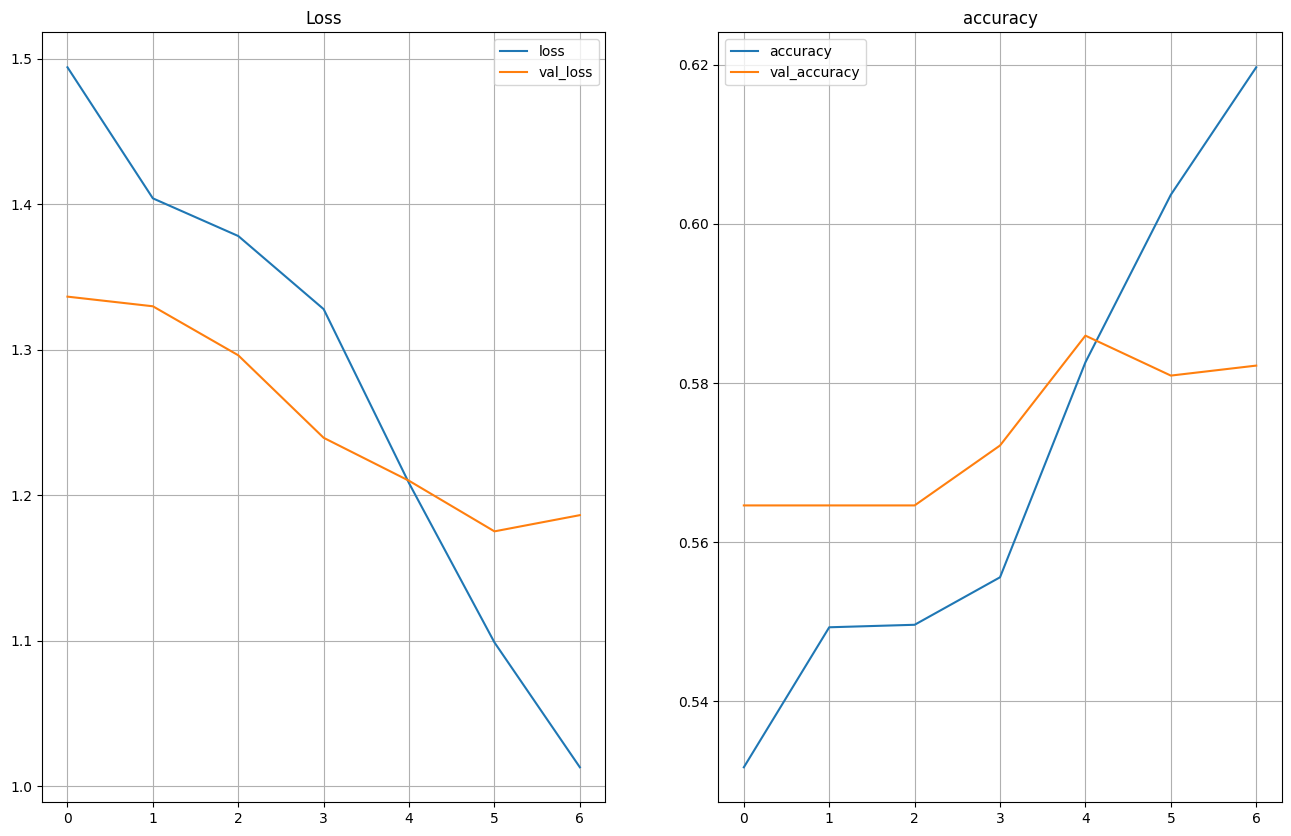

In [ ]:
fig,axs = plt.subplots(1,2)
axs[0].plot(history.history['loss'],label='loss')
axs[0].plot(history.history['val_loss'],label='val_loss')
axs[0].set_title('Loss')
axs[0].grid()
axs[0].legend()
axs[1].plot(history.history['accuracy'],label='accuracy')
axs[1].plot(history.history['val_accuracy'], label='val_accuracy')
axs[1].set_title('accuracy')
axs[1].grid()
axs[1].legend()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

In [ ]:
embeddings = lstm_model.layers[1].get_weights()[0]

In [ ]:
embeddings.shape

(10000, 64)

In [ ]:
vocabulary = seq(tokenizer.word_index.items()).sorted(lambda x: x[1]).map(lambda x:x[0]).to_list()

In [ ]:
len(embeddings),len(vocabulary)

(10000, 18295)

In [ ]:
out_v = io.open('embeddings/vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('embeddings/metadata.tsv', 'w', encoding='utf-8')
for word, embedding in zip(vocabulary,embeddings):
    out_v.write('\t'.join([str(x) for x in embedding]) + "\n")
    out_m.write(word + "\n")
out_v.close()
out_m.close()

In [238]:
from gensim.models import KeyedVectors,Word2Vec

In [270]:
train_sentences = seq(train_sequences_matrix)\
                    .map(lambda sentence: seq(sentence)\
                                        .filter(lambda x: x!=0)\
                                        .map(lambda idx: vocabulary[idx-1])
                                        .to_list()).to_list()

In [271]:
w2v_model = Word2Vec(train_sentences, vector_size=64, window=5, min_count=10, workers=4)

In [284]:
vocabulary[0]

'телефон'

In [285]:
w2v_model.wv.most_similar(vocabulary[0])

[('смартфон', 0.9987601041793823),
 ('брати', 0.9986369609832764),
 ('апарат', 0.9986273646354675),
 ('даний', 0.9984570741653442),
 ('взагалі', 0.998440682888031),
 ('новий', 0.9984332919120789),
 ('попередній', 0.9984185099601746),
 ('купляти', 0.9984017610549927),
 ('функція', 0.9983898997306824),
 ('відгук', 0.9983822107315063)]